# EURONEXT LISBON - Forecasting with LSTM

### Preliminary Tasks

#### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import os

#### Model Parameters

In [98]:
LOOK_BACK = 60
PERIODS_TO_PREDICT = 50
BATCH_SIZE = 8
EPOCHS=150
LEARN_RATE=0.001
VALIDATION_SPLIT=0.2
NUMBER_NEURONS=50
PERIOD='10y'
NUMBER_OF_LAYERS=2;




In [99]:
# Foreign stock tickers and names
#NAME_FOREIGN='IBEX 35'
#TICKER_FOREIGN='^IBEX'

NAME_FOREIGN='NYSE'
TICKER_FOREIGN='^NYA'

#NAME_FOREIGN='CAC 40'
#TICKER_FOREIGN='^FCHI'





#### Loading data from Yahoo

In [5]:
#df = pd.DataFrame(yf.Ticker('PSI20.LS').history(period = PERIOD))
#df=df.truncate(after="2023-02-01")
#df.to_csv('stocks10y.csv')

In [100]:
#df_other = pd.DataFrame(yf.Ticker(TICKER_FOREIGN).history(period = PERIOD)).truncate(after="2023-02-01")
#df_other.to_csv('stocks'+PERIOD+NAME_FOREIGN+'.csv')

C:\Users\queir\AppData\Local\Temp\ipykernel_10776\3563341454.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df_other = pd.DataFrame(yf.Ticker(TICKER_FOREIGN).history(period = PERIOD)).truncate(after="2023-02-01")


In [7]:
def load_df_other():
    return pd.read_csv('stocks'+PERIOD+NAME_FOREIGN+'.csv', index_col=0, parse_dates=True)


In [8]:
def load_df_portugal():
    return pd.read_csv('stocks.csv', index_col=0, parse_dates=True) if PERIOD=='5y' else pd.read_csv('stocks10y.csv', index_col=0, parse_dates=True)    

In [9]:
def load_multiple_index(end_date="2023-02-01") : 
    
    from datetime import date, timedelta

    # Load DFs
    df_other = load_df_other()
    df = load_df_portugal()


    # Truncate Data for different period analysis
    end_date=end_date + ' 00:00:00+00:00'
    df=df.truncate(after=pd.Timestamp(end_date))
    df_other=df_other.truncate(after=pd.Timestamp(end_date))


    #Correct Index so both tables have simple date format as index
    df_other.index = pd.to_datetime(df_other.index, utc=True).date + timedelta(days=1)
    df.index = pd.to_datetime(df.index + timedelta(hours=1), utc=True).date

    # get common indices
    common_indices = df.index.intersection(df_other.index)

    # select only rows with common indices
    df = df.loc[common_indices]
    df_other = df_other.loc[common_indices]

    return df, df_other

In [10]:
#df = pd.read_csv('stocks.csv', index_col=0, parse_dates=True)
df = pd.read_csv('stocks.csv', index_col=0, parse_dates=True)


In [11]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-04-06 00:00:00+01:00,5462.390137,5464.299805,5407.589844,5417.060059,58771500,0,0
2018-04-09 00:00:00+01:00,5492.680176,5507.770020,5444.040039,5448.990234,54414200,0,0
2018-04-10 00:00:00+01:00,5458.560059,5482.720215,5443.790039,5475.839844,47036700,0,0
2018-04-11 00:00:00+01:00,5464.990234,5505.879883,5462.930176,5465.709961,46407600,0,0
2018-04-12 00:00:00+01:00,5460.149902,5494.180176,5442.240234,5487.540039,73885100,0,0
...,...,...,...,...,...,...,...
2023-01-26 00:00:00+00:00,5923.089844,5976.750000,5917.790039,5961.770020,127496000,0,0
2023-01-27 00:00:00+00:00,5954.439941,5956.859863,5925.200195,5936.729980,69082900,0,0
2023-01-30 00:00:00+00:00,5908.270020,5917.919922,5873.939941,5876.200195,66985300,0,0


### EDA - Exploratory Data Analysis

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

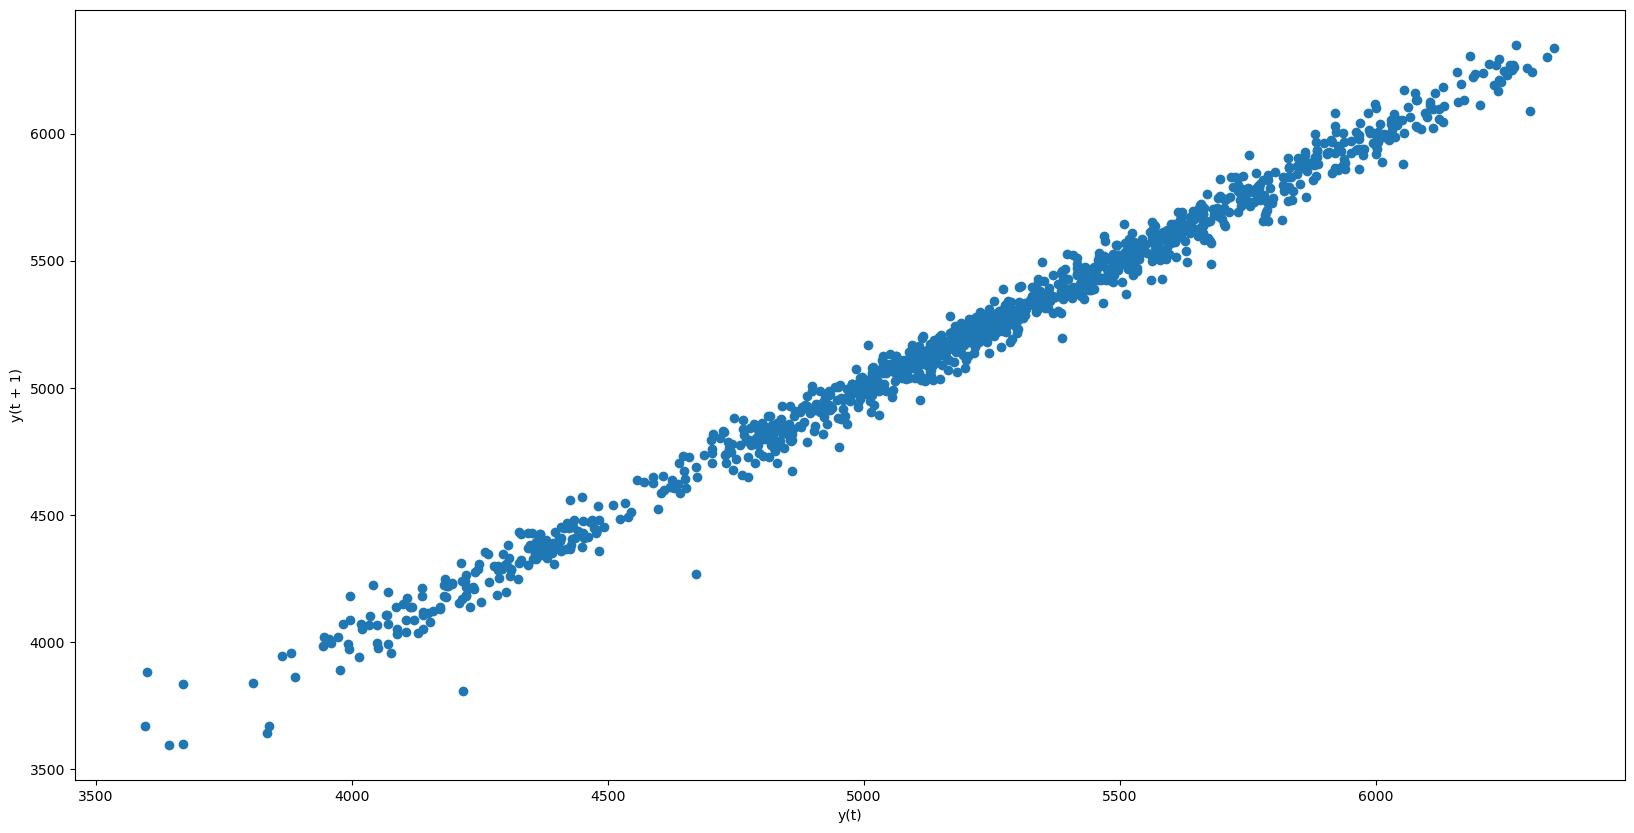

In [12]:
from pandas.plotting import lag_plot
lag_plot(df['Close'])

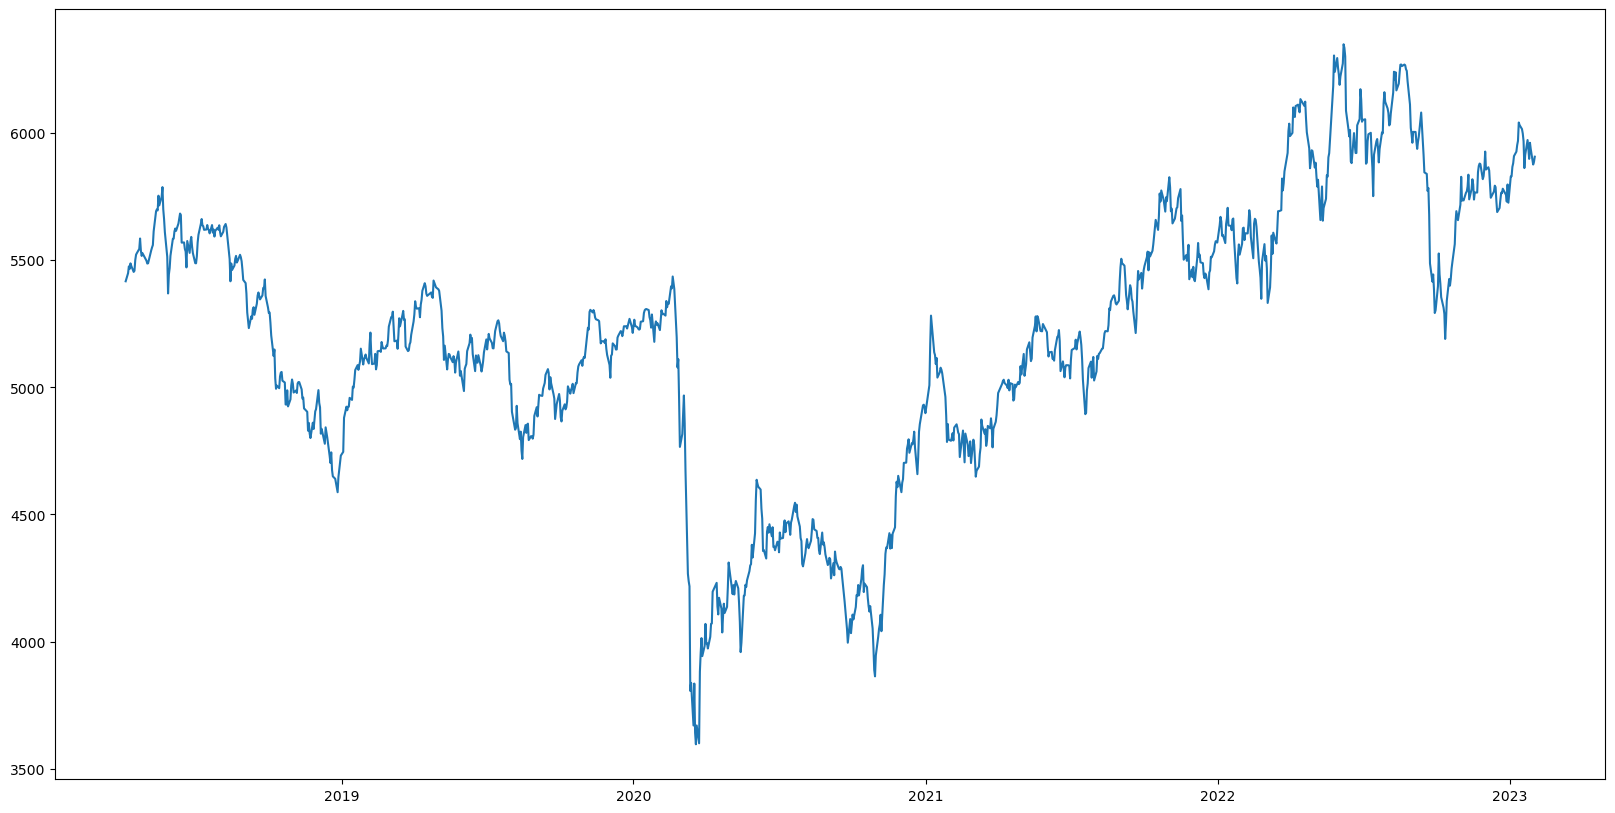

In [13]:
plt.plot(df['Close'])

In [14]:
df.describe()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1228.000000,1228.000000,1228.000000,1228.000000,1.228000e+03,1228.0,1228.0
mean,5197.101938,5227.978416,5164.300575,5195.969664,8.011948e+07,0.0,0.0
std,540.078839,539.456283,541.184158,541.032964,4.245179e+07,0.0,0.0
min,3554.699951,3613.669922,3500.020020,3596.080078,6.284000e+05,0.0,0.0
25%,4902.504883,4933.772583,4877.552368,4903.747314,5.143135e+07,0.0,0.0
50%,5218.574951,5240.354980,5191.094971,5219.030029,6.804180e+07,0.0,0.0
75%,5586.112549,5614.227417,5553.397461,5583.119873,9.607812e+07,0.0,0.0
max,6362.879883,6370.779785,6314.640137,6349.209961,3.252189e+08,0.0,0.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1228 entries, 2018-04-06 00:00:00+01:00 to 2023-02-01 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1228 non-null   float64
 1   High          1228 non-null   float64
 2   Low           1228 non-null   float64
 3   Close         1228 non-null   float64
 4   Volume        1228 non-null   int64  
 5   Dividends     1228 non-null   int64  
 6   Stock Splits  1228 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 76.8+ KB


### Setting the Model

##### Data Preparation

In [16]:
#Dropping unwanted columns
def selectData(type='univariate', datframe=df) :
    if type=='univariate' :
        data = datframe.drop(columns=['Open', 'High', 'Low','Volume','Dividends','Stock Splits'])
    else :
        data = datframe.drop(columns=['Open', 'High', 'Low','Dividends','Stock Splits'])
    size = len(data) - PERIODS_TO_PREDICT
    return data, size

In [17]:
# Divides Data into Train Data and Test Data
def divideData(data, size) : 
    train_data=data.values[0:size,:]
    test_data=data.values[size:,:]
    return train_data,test_data

In [18]:
# Scale Data between 0 and 1 
def scaleData(data,*scaler) :
    if len(scaler) == 1 :
        return scaler[0].fit_transform(data)
    else: 
        a1=scaler[0].fit_transform(data[:,0].reshape(-1,1))
        a2=scaler[1].fit_transform(data[:,1].reshape(-1,1))    
        scaled_data = np.array([a1,a2]).squeeze()
    return np.transpose(scaled_data)

In [19]:
def diffLogData (data, numVariables=1) : 
    if numVariables==1 :
        data = np.reshape(data,(data.shape[1], data.size))
        return np.diff(np.log(data)).T
    elif numVariables==2: 
        data=data.T
        return np.c_[np.diff(np.log(data[0])) , np.diff(np.log(data[1]))]

    #return np.transpose(np.diff(np.log(data)))

In [20]:
def undiffLogData (data, v0) :
    "Data is the array of logarithmic Differences and v0 is the initial absolute (price) of the test dataset"
    return v0 * np.concatenate(([1], np.exp(np.cumsum(data))))
    


In [21]:
def undiffLogData2 (actualData, diffLoggedData) :
    "Data is the array of logarithmic Differences and v0 is the actual prices on the period"
    #TODO in the data array add a "1" on position 0. - Concatenate.
    
    temp = np.exp(np.log(actualData[:-1]) - diffLoggedData)

    return np.concatenate((actualData[0:1], temp))

In [22]:
#%% Creates a vectors for training (2D numpy arrays)
def createTrainVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"
    
    x_train=[]

    for i in range(LOOK_BACK,len(data)):
        x_train.append(data[i-LOOK_BACK:i,0])
    
    return np.asarray(x_train)

In [23]:
def createBivTrainVector(data, size) :
    x0, x1 = [],[]
    for i in range(LOOK_BACK,size):
        x0.append(data[i-LOOK_BACK:i,0])
        x1.append(data[i-LOOK_BACK:i,1])
    
    x_data = np.array([np.asarray(x0),np.asarray(x1)]) 
    
    return np.transpose(x_data, (1, 2, 0))

    #x_data = np.array([np.asarray(x0),np.asarray(x1)]) 
    #return  np.reshape(x_data,(x_data.shape[1],x_data.shape[2],x_data.shape[0]))
   

In [24]:
#%% Creates a vectors with target data
def createTargetVector(data) :
    return np.asarray(data[LOOK_BACK:])

In [25]:
#%% Creates a vectors with target data for multiple horizon models (more than one day prediction)
def createTargetVectorHorizon(data,horizon) :
    "Horizon is the numbe of days predicted by the model"
    y_train=[]

    for i in range (LOOK_BACK,(len(data)-horizon)):
        y_train.append(data[i:i+horizon,0])
    
    return np.asarray(y_train)

In [26]:
#%% Creates a vectors with target data
from keras.utils import to_categorical
def createTargetClassVector(data, numCat=5) :
    data = data[LOOK_BACK:]
    percentiles = []
    y_data = []

    # Calculate Percentiles
    for i in range(0,numCat) :
            percentiles.append(np.percentile(data, (100/numCat)*i))
            
            
    # fill the vector with a classification number from 0 to [numCat]
    for i in range(0,len(data)):
        for j in reversed(range(0,numCat)) :
            if(data[i]>=percentiles[j]):
                y_data.append(j)
                break
                

    from keras.utils import to_categorical       
    #one hot encode the vector 
    return np.asarray(to_categorical(y_data, num_classes=len(np.unique(y_data))))
    


In [27]:
# CREATES a VECTOR FOR TEST WITH LENGTH = PERIODS_TO_PREDICT + LOOK_BACK
def selectTestData (data, size):
    test_data=data[size-LOOK_BACK:].values
    return test_data.reshape(-1,1)
    

In [28]:
# Creates an array for predicting PERIODS_TO_PREDICT
def createTestVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    X_test=[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        X_test.append(data[i-LOOK_BACK:i,0])
    X_test=np.array(X_test)

    #Reshaopes the vector for the predict function
    return np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [29]:
def createBivTestVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    x0,x1=[],[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        x0.append(data[i-LOOK_BACK:i,0])
        x1.append(data[i-LOOK_BACK:i,1])
    
    X_test = np.array([np.array(x0),np.array(x1)])
        
    return np.transpose(X_test, (1, 2, 0))

    #X_test = np.array([np.array(x0),np.array(x1)])
    #return np.reshape(X_test, (X_test.shape[1],X_test.shape[2],X_test.shape[0]))

#### LSTM Model

In [30]:
#%% Creates a LSTM Sequential model
def createLstmModel (data,outputs=1,type="regression") : 

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
    try:
        numSources = data.shape[2]
    except:
        numSources = 1
    

    input_shape=(np.shape(data)[1],numSources)
    lstm_model=Sequential()

    if (NUMBER_OF_LAYERS==1):
        lstm_model.add(LSTM(units=NUMBER_NEURONS, input_shape=input_shape))
    else:
        if(NUMBER_OF_LAYERS==2):
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            #lstm_model.add(Dropout(0.01))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2)))
        else:
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2),return_sequences=True))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/4)))

    #lstm_model.add(Dropout(0.01))
    
    # For single or multiple output (regression)
    if (type=="regression") : 
        lstm_model.add(Dense(units=outputs))
        lstm_model.compile(loss='mse',
                    optimizer=Adam(learning_rate=LEARN_RATE)
                    )
    #For Multiple outputs ( #(Category/Calssification))
    else : 
        lstm_model.add(Dense(units=outputs, activation = 'softmax'))
        lstm_model.compile(loss='categorical_crossentropy',
                metrics=['accuracy'],
                optimizer=Adam(learning_rate=LEARN_RATE)
                )
    return lstm_model

In [31]:
#%% Trains the model -  data
def trainLstmModel (model, x_train, y_train) :
    return model.fit(x_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_split=VALIDATION_SPLIT,
                verbose='auto')

In [32]:
def plotHistory(history, yaxis="MAE", title="") :
    plt.plot(history.history['loss'], label='Train Data')
    plt.plot(history.history['val_loss'], label='Validation Data')
    plt.xlabel("EPOCHS")
    plt.ylabel(yaxis)
    plt.title(title, fontsize=20)
    plt.legend()
    plt.show()

# == RUNNING THE MODEL ==

#### Linear Univariate model

This model gives an estimate the PSI-20 value  based on the quotations of a sliding window of the [LOOK_BACK] days, before the estimated value.

In [64]:
#df=df.truncate(after=pd.Timestamp('2021-08-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='univariate') 
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler)
x_train_data = createTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data)

test_data=selectTestData(global_data,size_train_data)
scaled_test_data=scaleData(test_data,scaler)
X_test = createTestVector(scaled_test_data)

In [65]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[0.66142175 0.67301952 0.68277192 ... 0.71128137 0.70189929 0.6873122 ]
 [0.67301952 0.68277192 0.67909251 ... 0.70189929 0.6873122  0.68708714]
 [0.68277192 0.67909251 0.6870217  ... 0.6873122  0.68708714 0.69708304]
 ...
 [0.94719823 0.91393797 0.88062681 ... 0.80715397 0.79970062 0.77815803]
 [0.91393797 0.88062681 0.87143007 ... 0.79970062 0.77815803 0.78817202]
 [0.88062681 0.87143007 0.85933109 ... 0.77815803 0.78817202 0.78821565]]

y data - target

[[0.68708714]
 [0.69708304]
 [0.71674054]
 ...
 [0.78817202]
 [0.78821565]
 [0.8174441 ]]


In [66]:
lstm_model = createLstmModel(x_train_data)
print(lstm_model.summary())
history=trainLstmModel(lstm_model, x_train_data, y_train_data)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
28/28 [==============================] - 4s 62ms/step - loss: 0.3448 - val_loss: 0.8096
Epoch 2/150
28/28 [==============================] - 1s 35ms/step - loss: 0.3299 - val_loss: 0.7781
Epoch 3/150
28/28 [==============================] - 1s 35ms/step - loss: 0.3155 - val_loss: 0.7479
Epoch 4/150

KeyboardInterrupt: 

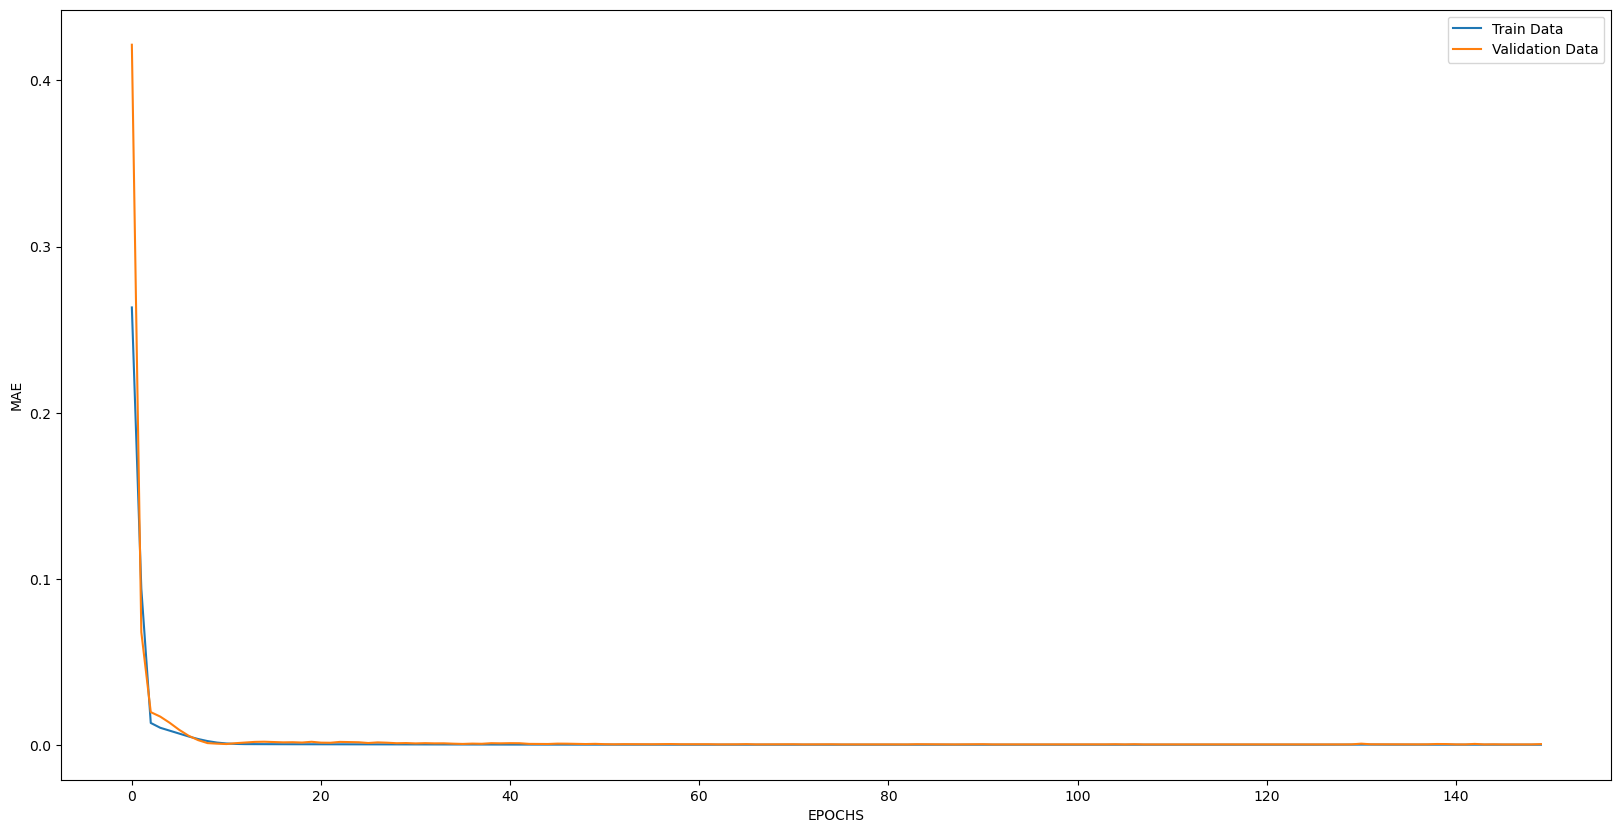

In [ ]:
plotHistory(history)

#### Bivariate Model

In addition to the univariate method (above) This model also considers the volume of trading during the [LOOK_BACK] days before, to estimate the value of the index. 

In [157]:
#df=df.truncate(after=pd.Timestamp('2021-08-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='bivariate') 
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaler2=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler,scaler2)
x_train_data = createBivTrainVector(scaled_train_data, size_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])
test_data=global_data[size_train_data-LOOK_BACK:].values
scaled_test_data=scaleData(test_data,scaler,scaler2)
X_test = createBivTestVector(scaled_test_data)


In [158]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[[0.66142175 0.17912755]
  [0.67301952 0.16570356]
  [0.68277192 0.14297492]
  ...
  [0.68674555 0.2204778 ]
  [0.6871125  0.17635174]
  [0.70163042 0.18006842]]

 [[0.67301952 0.16570356]
  [0.68277192 0.14297492]
  [0.67909251 0.14103678]
  ...
  [0.6871125  0.17635174]
  [0.70163042 0.18006842]
  [0.70591656 0.35645313]]

 [[0.68277192 0.14297492]
  [0.67909251 0.14103678]
  [0.6870217  0.2256896 ]
  ...
  [0.70163042 0.18006842]
  [0.70591656 0.35645313]
  [0.70985029 0.27453391]]

 ...

 [[0.68861984 0.29445501]
  [0.71454665 0.29162714]
  [0.74664843 0.66400218]
  ...
  [0.80715397 0.42877965]
  [0.79970062 0.46205665]
  [0.77815803 0.34610378]]

 [[0.71454665 0.29162714]
  [0.74664843 0.66400218]
  [0.76157321 0.32685276]
  ...
  [0.79970062 0.46205665]
  [0.77815803 0.34610378]
  [0.78817202 0.20667179]]

 [[0.74664843 0.66400218]
  [0.76157321 0.32685276]
  [0.75532216 0.40458639]
  ...
  [0.77815803 0.34610378]
  [0.78817202 0.20667179]
  [0.78821565 0.14928194]]]

y

In [159]:
np.shape(x_train_data)[1],x_train_data.shape[2]

(20, 2)

In [160]:

lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 50)            10600     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
116/116 [==============================] - 4s 14ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 2/150
116/116 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 3/150
116/116 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch

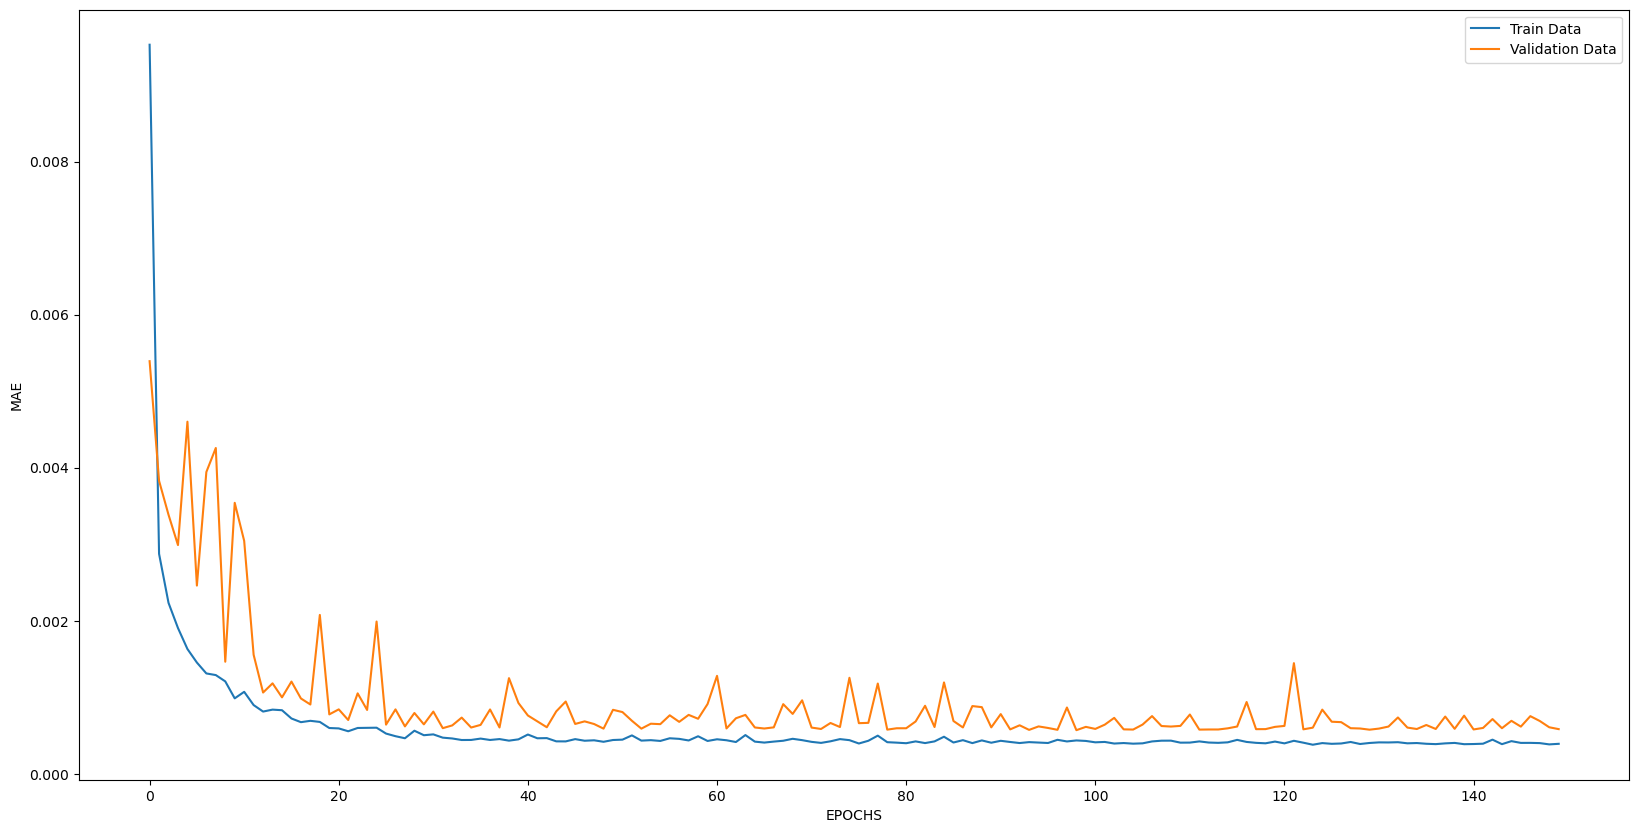

In [161]:

plotHistory(history)

#### Diff(log) model

This model works in similar way as the Linear univariate model. The difference is that the data is based on the difference of the logaritms between two consecutive days, providing insights on the daily variation in relation to the previous day.

In [ ]:
df = load_df_other()
df = df.truncate(after=pd.Timestamp('2021-05-05 00:00:00+00:00'))
df


In [127]:

global_data, size_train_data = selectData(type='univariate',datframe=df) 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
scaled_train_data=diffLogData(train_data)
x_train_data = createTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data)
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data)


In [ ]:

#EPOCHS=5
lstm_difflog_model = createLstmModel(x_train_data)
print(lstm_difflog_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)      


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 20, 25)            7600      
                                                                 
 lstm_4 (LSTM)               (None, 12)                1824      
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 19,837
Trainable params: 19,837
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
18/18 [==============================] - 9s 186ms/step - loss: 1.4660e-04 - val_loss: 1.5411e-04
Epoch 2/150
18/18 [==============================] - 1s 53ms/step - 

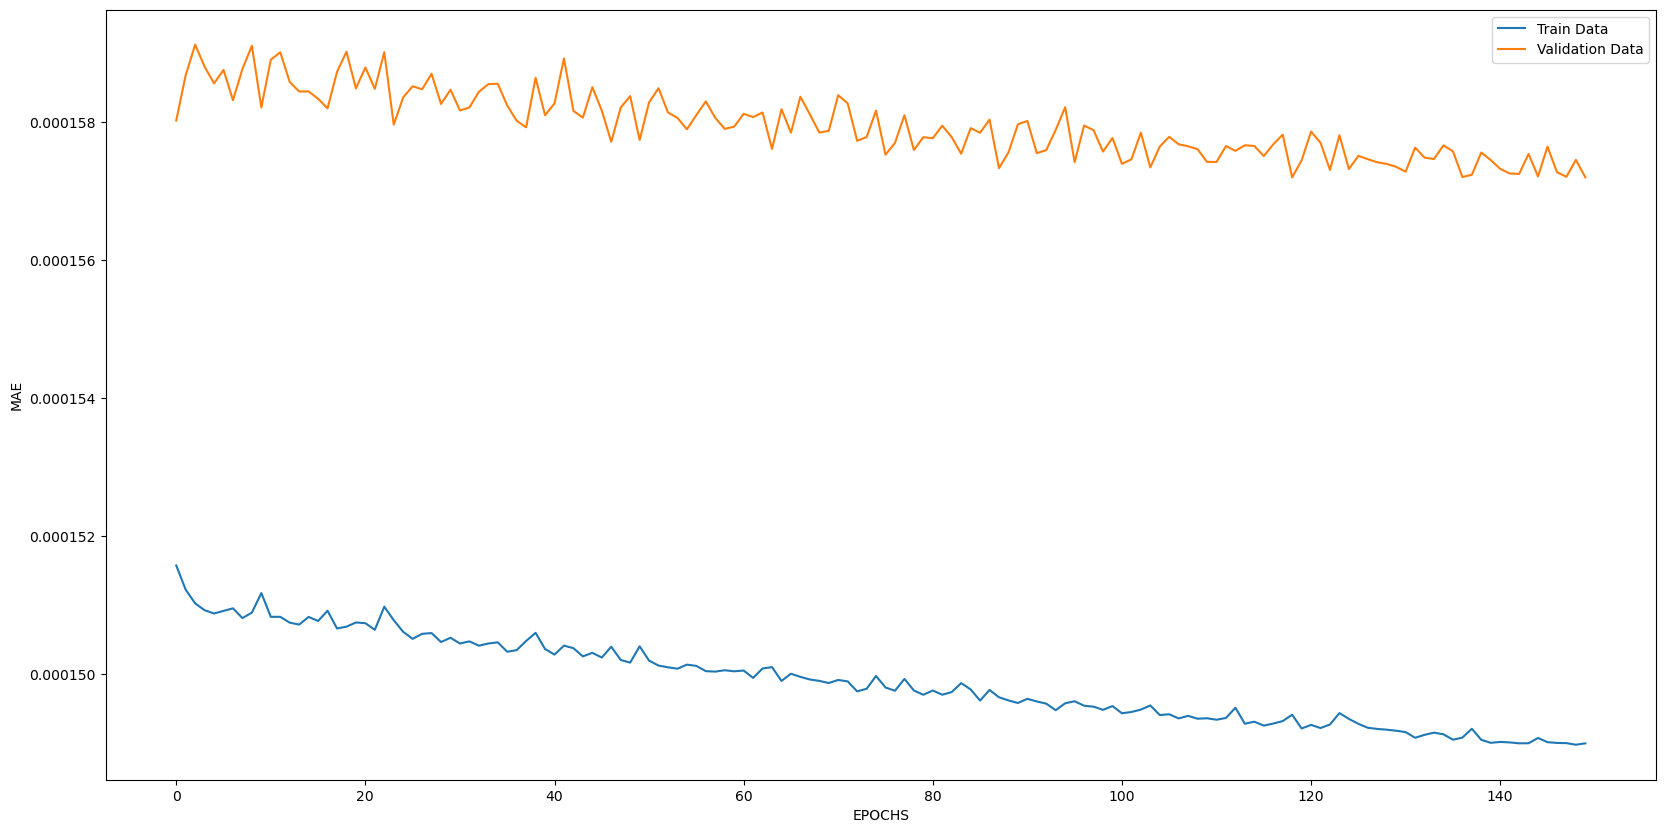

In [ ]:
                        
plotHistory(history)


#### Classification Model (based on Diff(log) model)

##### This model classifies the forecast into n different categories

In [154]:
#df=df.truncate(after=pd.Timestamp('2022-02-01 00:00:00+00:00'))
df = load_df_portugal();
global_data, size_train_data = selectData(type='univariate', datframe=df) 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
difflogged_train_data=diffLogData(train_data)


In [155]:

#Number of CAtegories to classify the data
numCat=3

# Preparing the arrays for the model
x_train_data = createTrainVector(difflogged_train_data)


In [156]:

x_train_data = x_train_data[:-1]
y_train_data = createTargetClassVector(difflogged_train_data, numCat)


# Preparing Test Data
test_data=selectTestData(global_data,size_train_data)
difflogged_test_data=diffLogData(test_data)
X_test = createTestVector(difflogged_test_data)
Y_test = createTargetClassVector(difflogged_test_data, numCat)




In [157]:
#Show how many observations are in each percentile

numCat=y_train_data.shape[1]
for i in range(0, numCat):
    print('percentile ' + str(i*int(100/numCat)) + ' = ' + str(np.count_nonzero(y_train_data[:,i] == 1)))


percentile 0 = 805
percentile 33 = 806
percentile 66 = 805


In [158]:
lstm_class_model = createLstmModel(x_train_data, y_train_data.shape[1], type="classification")
print(lstm_class_model.summary())
print(len(x_train_data))
print("number of Epochs " + str(EPOCHS))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 18,078
Trainable params: 18,078
Non-trainable params: 0
_________________________________________________________________
None
2415
number of Epochs 150


In [159]:

history = trainLstmModel(lstm_class_model, x_train_data, y_train_data)


Epoch 1/150
242/242 [==============================] - 5s 12ms/step - loss: 1.0999 - accuracy: 0.3364 - val_loss: 1.1018 - val_accuracy: 0.2940
Epoch 2/150
242/242 [==============================] - 2s 9ms/step - loss: 1.0991 - accuracy: 0.3411 - val_loss: 1.0998 - val_accuracy: 0.2940
Epoch 3/150
242/242 [==============================] - 2s 9ms/step - loss: 1.0991 - accuracy: 0.3421 - val_loss: 1.0988 - val_accuracy: 0.3023
Epoch 4/150
242/242 [==============================] - 2s 9ms/step - loss: 1.0990 - accuracy: 0.3380 - val_loss: 1.0990 - val_accuracy: 0.3188
Epoch 5/150
242/242 [==============================] - 2s 9ms/step - loss: 1.0988 - accuracy: 0.3406 - val_loss: 1.0994 - val_accuracy: 0.3230
Epoch 6/150
242/242 [==============================] - 2s 9ms/step - loss: 1.0986 - accuracy: 0.3458 - val_loss: 1.1001 - val_accuracy: 0.2940
Epoch 7/150
242/242 [==============================] - 2s 9ms/step - loss: 1.0977 - accuracy: 0.3318 - val_loss: 1.0962 - val_accuracy: 0.368

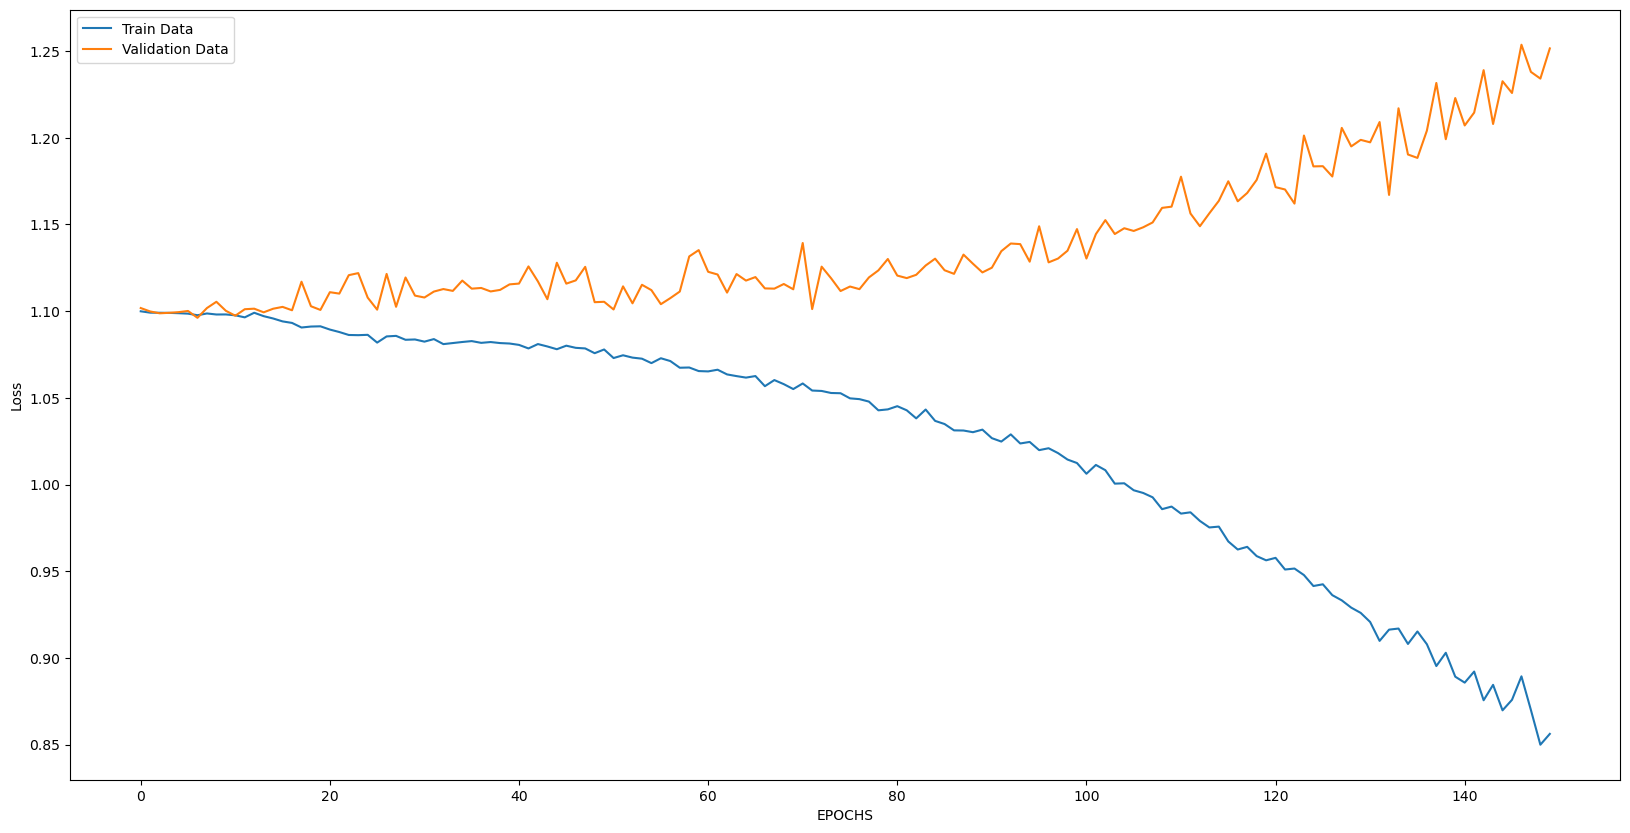

In [160]:
plotHistory(history, yaxis="Loss")

## Linear Model with foreign X_Data

#### This model predicts the PSI-20 index based on the information from the last 90 days of another stock exchange

In [ ]:
df, df_other = load_multiple_index(end_date="2022-08-01")
df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
2018-05-04,5493.379883,5511.290039,5485.919922,5487.790039,57870500,0,0
2018-05-07,5513.689941,5531.500000,5506.319824,5527.759766,59076900,0,0
2018-05-08,5510.660156,5539.560059,5480.609863,5539.560059,116329700,0,0
2018-05-09,5557.060059,5568.930176,5542.729980,5550.390137,89739500,0,0
2018-05-10,5569.100098,5576.879883,5533.459961,5559.620117,62554800,0,0
...,...,...,...,...,...,...,...
2022-07-26,6020.549805,6048.160156,5998.979980,5998.979980,88841300,0,0
2022-07-27,6052.080078,6116.770020,6022.500000,6116.720215,130040900,0,0
2022-07-28,6159.060059,6211.040039,6092.839844,6160.720215,144036400,0,0
2022-07-29,6160.759766,6215.740234,6091.399902,6123.229980,107436700,0,0


In [ ]:
df_other

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2018-05-04,5495.709961,5516.049805,5485.990234,5516.049805,85333000,0,0
2018-05-07,5511.939941,5532.120117,5503.700195,5531.419922,45591900,0,0
2018-05-08,5523.910156,5529.149902,5496.390137,5521.930176,70214400,0,0
2018-05-09,5520.649902,5535.240234,5511.580078,5534.629883,72894200,0,0
2018-05-10,5532.370117,5547.200195,5522.910156,5545.950195,48972800,0,0
...,...,...,...,...,...,...,...
2022-07-26,6225.169922,6243.859863,6194.959961,6211.450195,60556300,0,0
2022-07-27,6206.250000,6267.799805,6199.930176,6257.939941,69640600,0,0
2022-07-28,6304.129883,6339.209961,6236.569824,6339.209961,92169500,0,0
2022-07-29,6413.100098,6472.270020,6397.910156,6448.500000,103116600,0,0


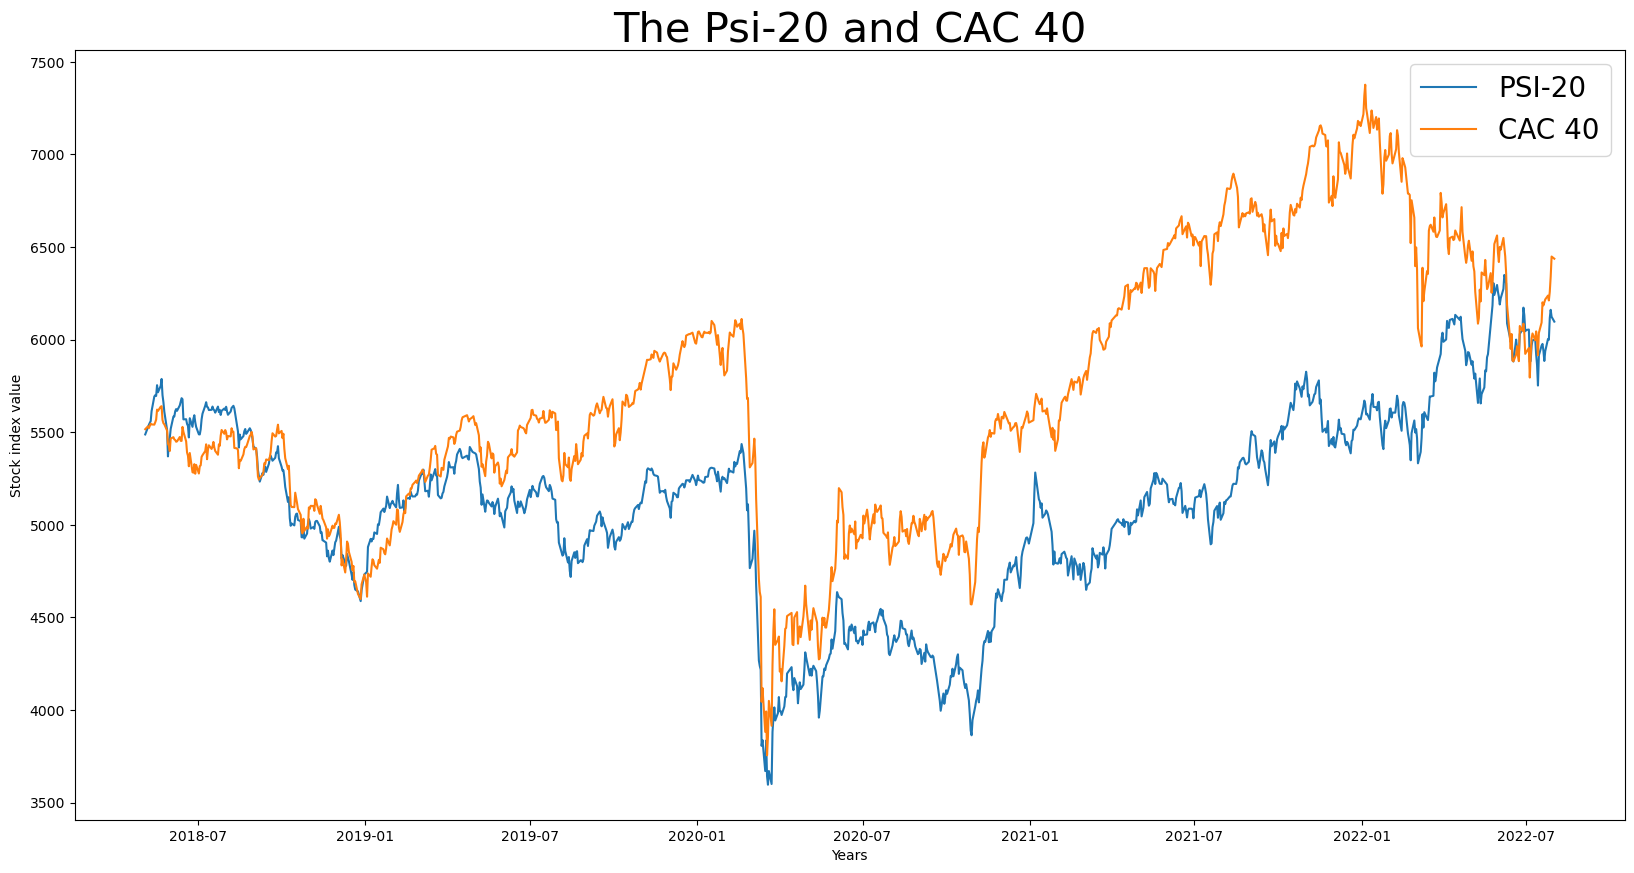

In [ ]:
plt.plot(df['Close'], label='PSI-20')
plt.plot(df_other['Close'], label=NAME_FOREIGN)
plt.xlabel("Years")
plt.ylabel("Stock index value")
plt.title("The Psi-20 and "+NAME_FOREIGN, fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [ ]:
# Cleans unwanted columns leaving only index and close value
global_data, size_train_data = selectData(type='univariate', datframe=df_other) 

#Divides the data in train_data and test_data
train_data,test_data = divideData(global_data, size_train_data)

#Scales the data
scaler_f=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler_f)

#Create the vector for X_train_data
x_train_data = createTrainVector(scaled_train_data, size_train_data)

In [ ]:
# Cleans unwanted columns leaving only index and close value
global_data_p, size_train_data_p = selectData(type='univariate', datframe=df) 

#Divides the data in train_data and test_data
train_data_p,test_data_p = divideData(global_data_p, size_train_data_p)

#Scales the data
scaler_p=MinMaxScaler(feature_range=(0,1))
scaled_train_data_p=scaleData(train_data_p,scaler_p)

#Create the vector for Y_train_data 
y_train_data = createTargetVector(scaled_train_data_p)

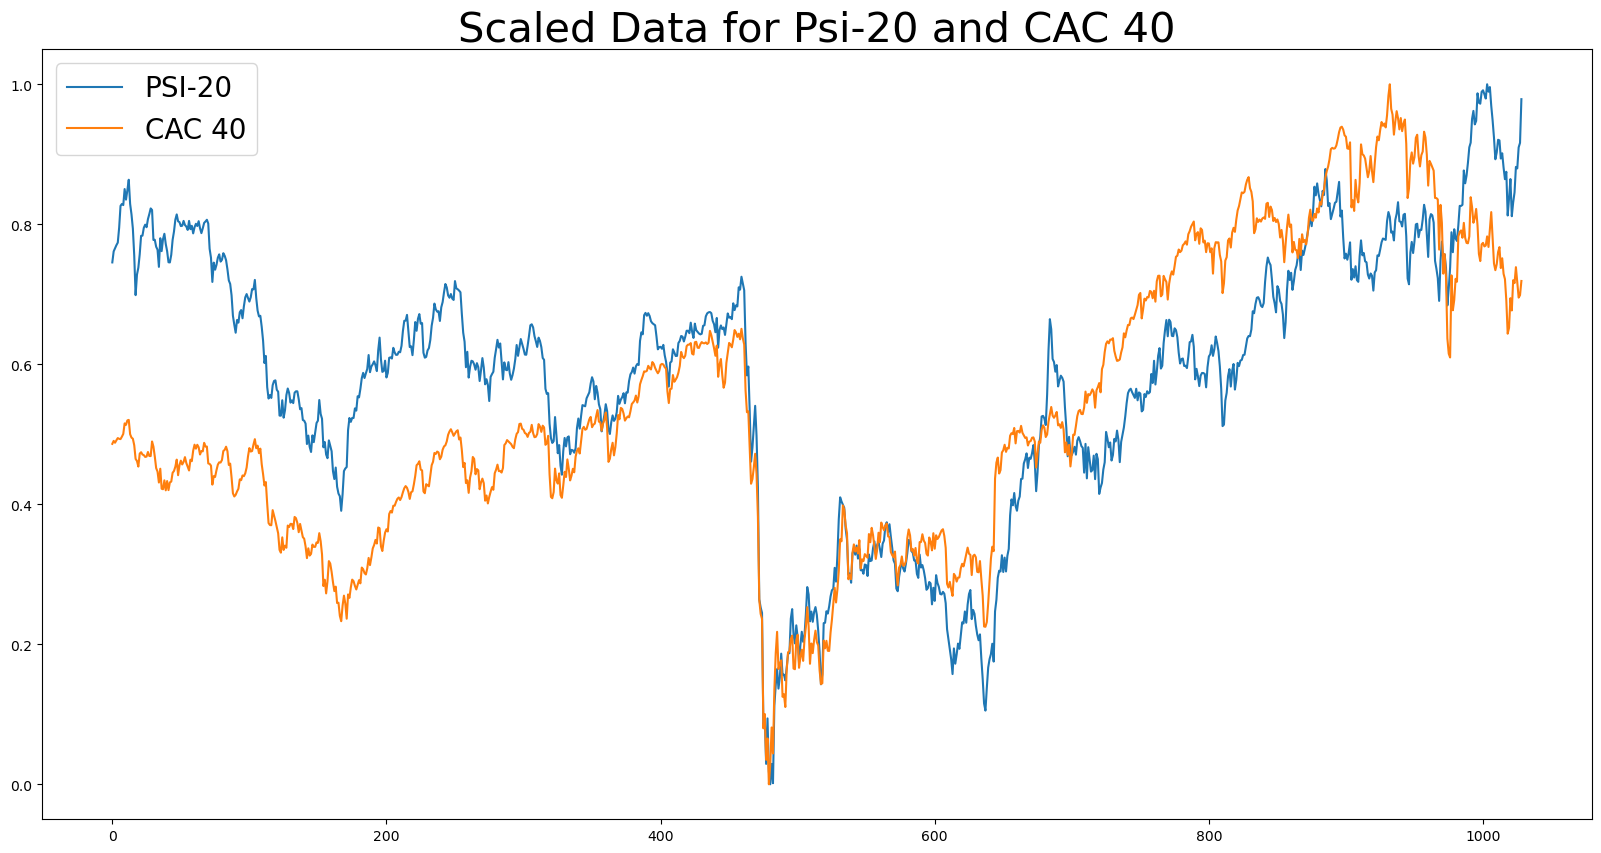

In [ ]:
plt.plot(scaled_train_data_p, label='PSI-20')
plt.plot(scaled_train_data, label=NAME_FOREIGN)
#plt.plot(y_train_data, label='y_target')
#plt.xlabel("Years")
#plt.ylabel("Stock index value")
plt.title("Scaled Data for Psi-20 and "+ NAME_FOREIGN, fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [ ]:
#Preaparing the X_test matrix
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=scaleData(test_data,scaler_f)
X_test = createTestVector(scaled_test_data)

print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)


In [ ]:
lstm_model = createLstmModel(x_train_data)
print(lstm_model.summary())
history=trainLstmModel(lstm_model, x_train_data, y_train_data)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 90, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
27/27 [==============================] - 4s 73ms/step - loss: 0.1359 - val_loss: 0.0207
Epoch 2/200
27/27 [==============================] - 1s 49ms/step - loss: 0.0163 - val_loss: 0.0185
Epoch 3/200
27/27 [==============================] - 1s 48ms/step - loss: 0.0141 - val_loss: 0.0209
Epoch 4/2

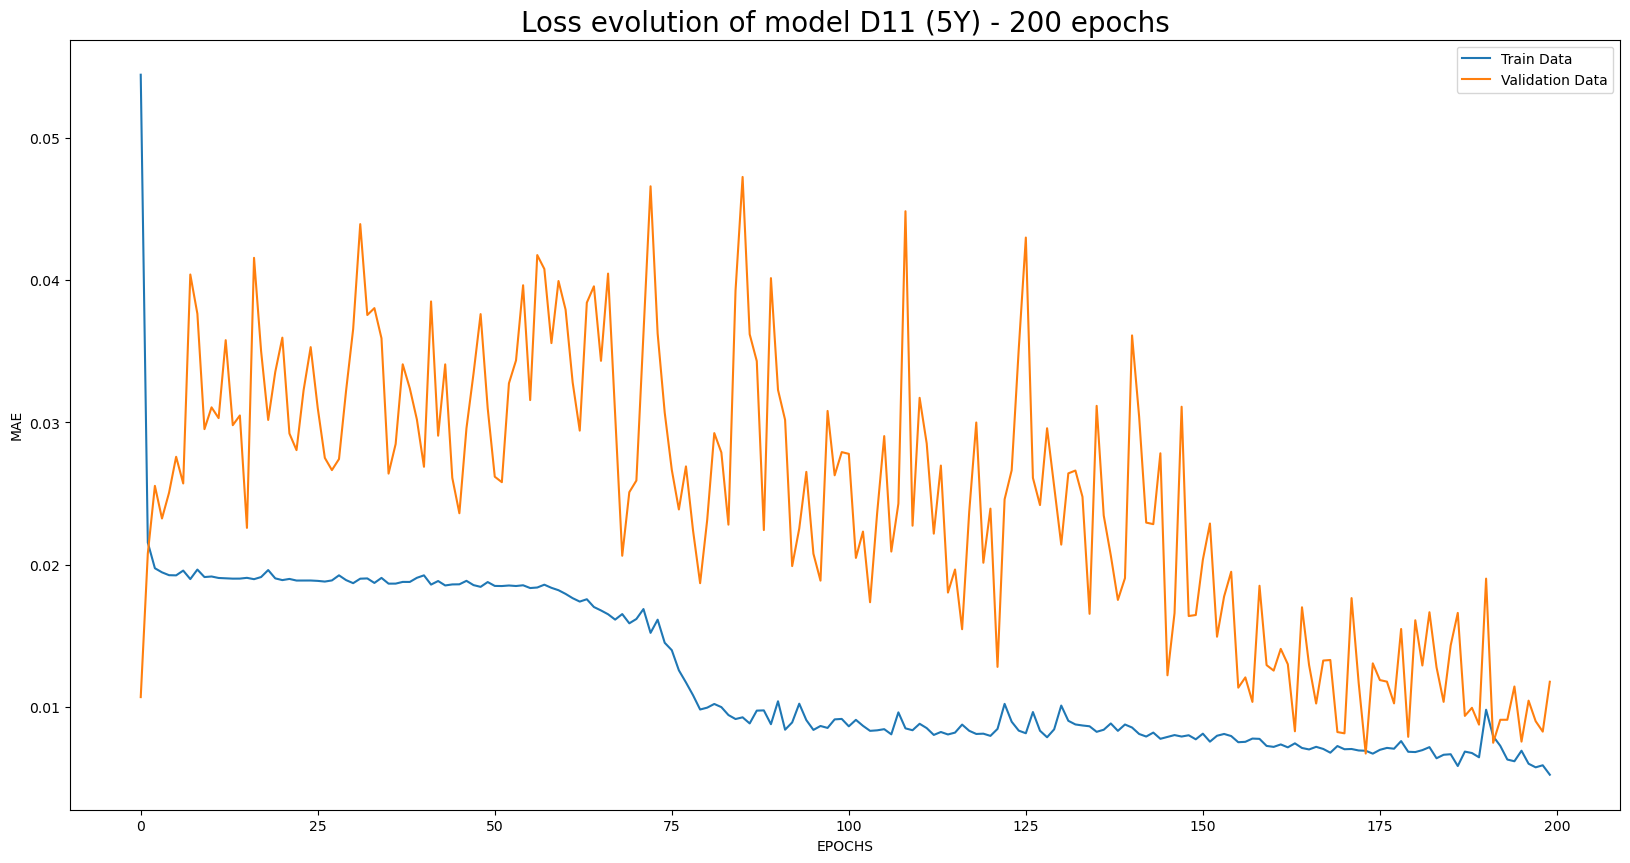

In [ ]:
plotHistory(history, title="Loss evolution of model D21 (5Y) - 200 epochs")

## MULTI-INDEX Stocks model

#### This model predicts the PSI-20 index based on the information from the last 90 days of the PSI-20 AND another stock exchange

In [101]:
# Loads Data (includes disregarding dates only present in one dataframe)
df, df_other = load_multiple_index(end_date="2023-01-01")

# Cleans PSI-20 unwanted columns leaving only index and close value
global_data_p, size_train_data = selectData(type='univariate', datframe=df) 


# Cleans Foreign unwanted columns leaving only index and close value
global_data_f, size_train_data_f = selectData(type='univariate', datframe=df_other) 

#Renames the column of the close value of the foreign stock exchange
global_data_f.rename(columns = {'Close':'Other1'}, inplace = True)

#NECESSARY TO RECALCULATE??
size_train_data=len(global_data)-PERIODS_TO_PREDICT

# Joins the thow tables in one
global_data=global_data_p.join(global_data_f["Other1"])
global_data



,Close,Other1
2013-05-31,5939.430176,9460.049805
2013-06-04,5930.990234,9357.080078
2013-06-05,5873.109863,9320.080078
2013-06-06,5793.189941,9178.410156
2013-06-07,5850.069824,9260.480469
...,...,...
2022-12-22,5763.540039,15219.549805
2022-12-23,5781.180176,15081.530273
2022-12-28,5730.279785,15218.259766
2022-12-29,5797.759766,15037.320312


In [102]:
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaler2=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler,scaler2)
x_train_data = createBivTrainVector(scaled_train_data, size_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])
test_data=global_data[size_train_data-LOOK_BACK:].values
scaled_test_data=scaleData(test_data,scaler,scaler2)
X_test = createBivTestVector(scaled_test_data)


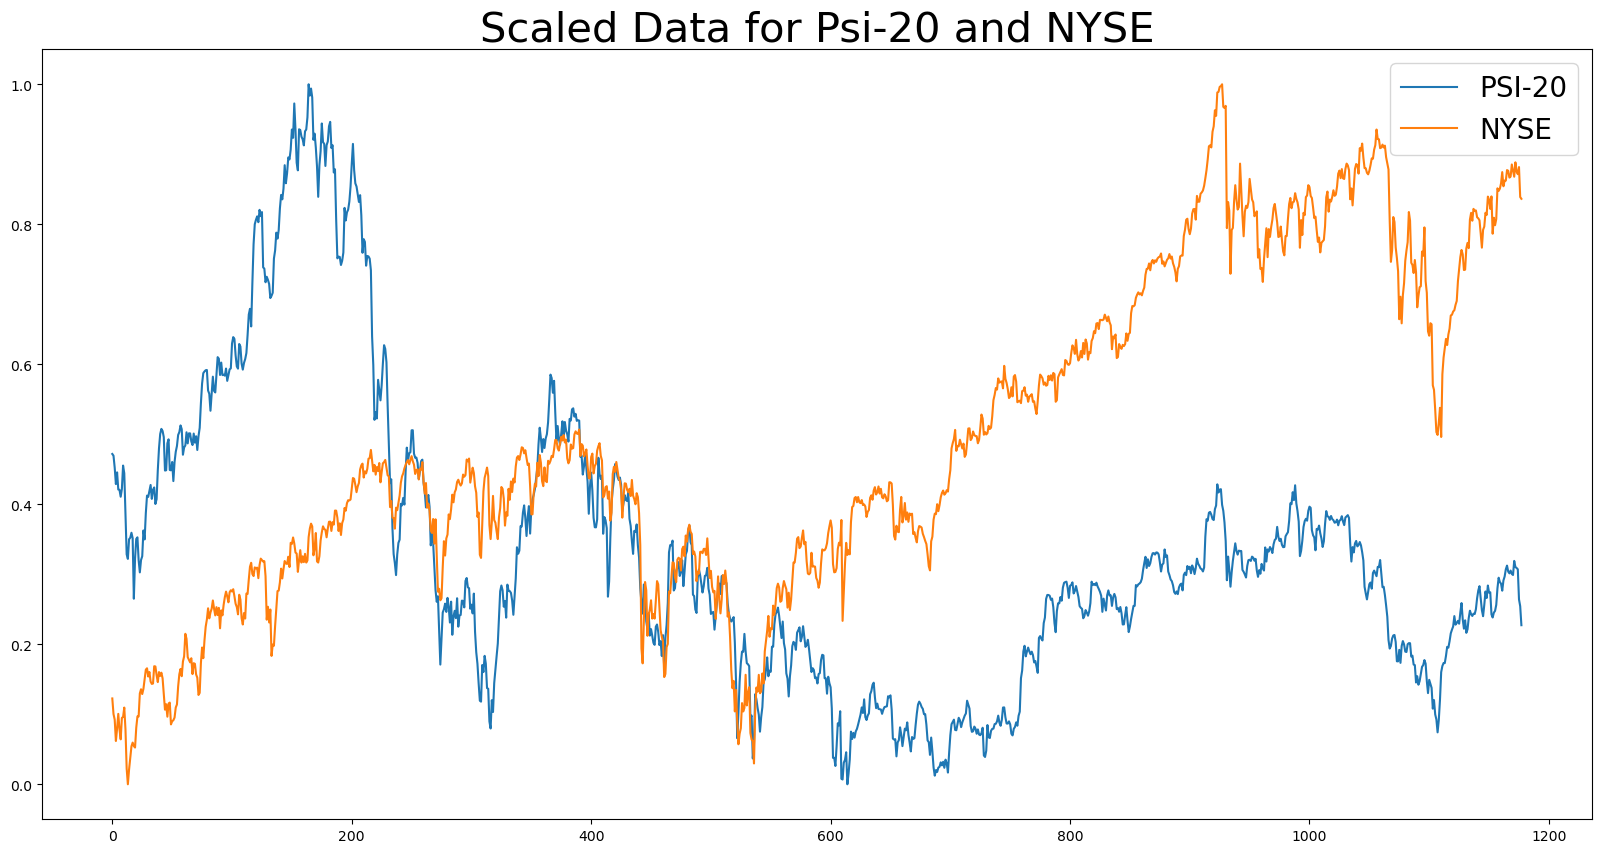

In [103]:
plt.plot(scaled_train_data[:,0], label='PSI-20')
plt.plot(scaled_train_data[:,1], label=NAME_FOREIGN)
#plt.plot(y_train_data, label='y_target')
#plt.xlabel("Years")
#plt.ylabel("Stock index value")
plt.title("Scaled Data for Psi-20 and "+ NAME_FOREIGN, fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [ ]:
"""
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)
"""

'\nprint("x data\n")\nprint(x_train_data)\nprint("\ny data - target\n")\nprint(y_train_data)\n'

In [104]:
lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            10600     
                                                                 
 lstm_9 (LSTM)               (None, 25)                7600      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
112/112 [==============================] - 5s 27ms/step - loss: 0.0096 - val_loss: 0.0010
Epoch 2/150
112/112 [==============================] - 2s 22ms/step - loss: 0.0029 - val_loss: 9.5020e-04
Epoch 3/150
112/112 [==============================] - 2s 22ms/step - loss: 0.0023 - val_loss: 0.0012

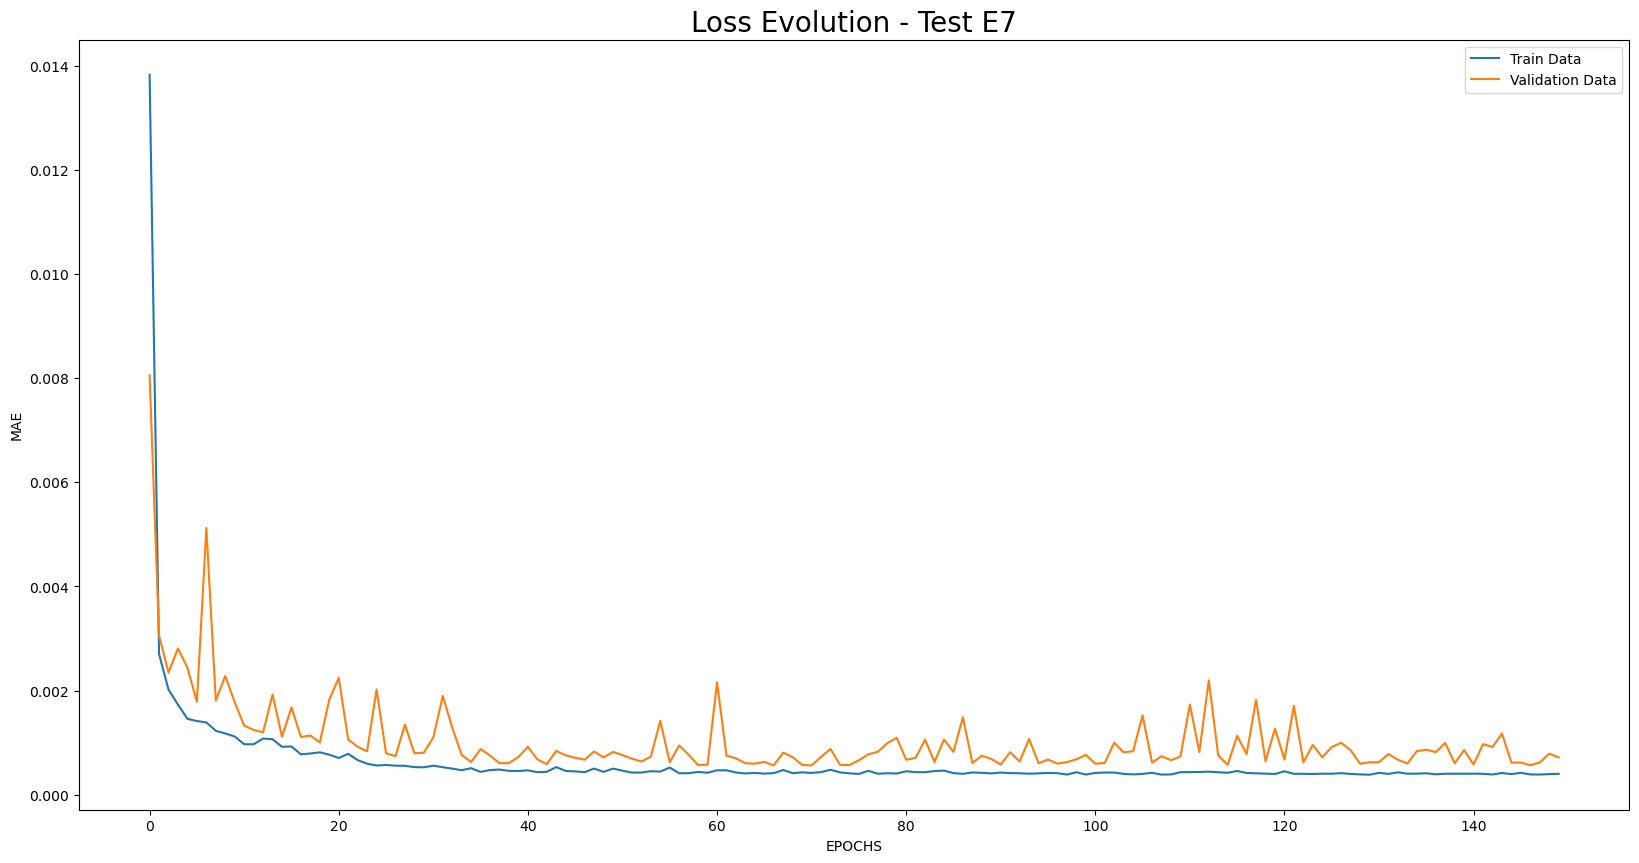

In [172]:
plotHistory(history,title="Loss Evolution - Test E7 | PSI20 " + NAME_FOREIGN +"." )

## Multi predictor

In [101]:
HORIZON = 10
PERIODS_TO_PREDICT = HORIZON + 2

df = load_df_portugal()
df = df.truncate(after=pd.Timestamp('2022-04-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='univariate',datframe=df) 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
scaled_train_data=diffLogData(train_data)
df



,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-04-06 00:00:00+01:00,5462.390137,5464.299805,5407.589844,5417.060059,58771500,0,0
2018-04-09 00:00:00+01:00,5492.680176,5507.770020,5444.040039,5448.990234,54414200,0,0
2018-04-10 00:00:00+01:00,5458.560059,5482.720215,5443.790039,5475.839844,47036700,0,0
2018-04-11 00:00:00+01:00,5464.990234,5505.879883,5462.930176,5465.709961,46407600,0,0
2018-04-12 00:00:00+01:00,5460.149902,5494.180176,5442.240234,5487.540039,73885100,0,0
...,...,...,...,...,...,...,...
2022-03-28 00:00:00+01:00,5843.839844,5921.040039,5843.839844,5904.990234,214343800,0,0
2022-03-29 00:00:00+01:00,5944.799805,5964.379883,5893.839844,5921.839844,250690800,0,0
2022-03-30 00:00:00+01:00,5928.220215,6007.680176,5909.950195,6007.680176,183456100,0,0


In [102]:
#This x_train is smaller as the horizon of prediction values are removed.
x_train_data = createTrainVector(scaled_train_data[:-HORIZON])
#And Y train data is bi-dimensional
y_train_data = createTargetVectorHorizon(scaled_train_data, HORIZON)

In [103]:

#Test Data Preparation
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data[:-HORIZON])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 dense_2 (Dense)             (None, 10)                260       
                                                                 
Total params: 18,260
Trainable params: 18,260
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
24/24 [==============================] - 4s 69ms/step - loss: 1.4612e-04 - val_loss: 9.7301e-05
Epoch 2/150
24/24 [==============================] - 1s 34ms/step - loss: 1.4606e-04 - val_loss: 9.7328e-05
Epoch 3/150
24/24 [==============================] - 1s 35ms/step - loss: 1.4604e-04 - val_lo

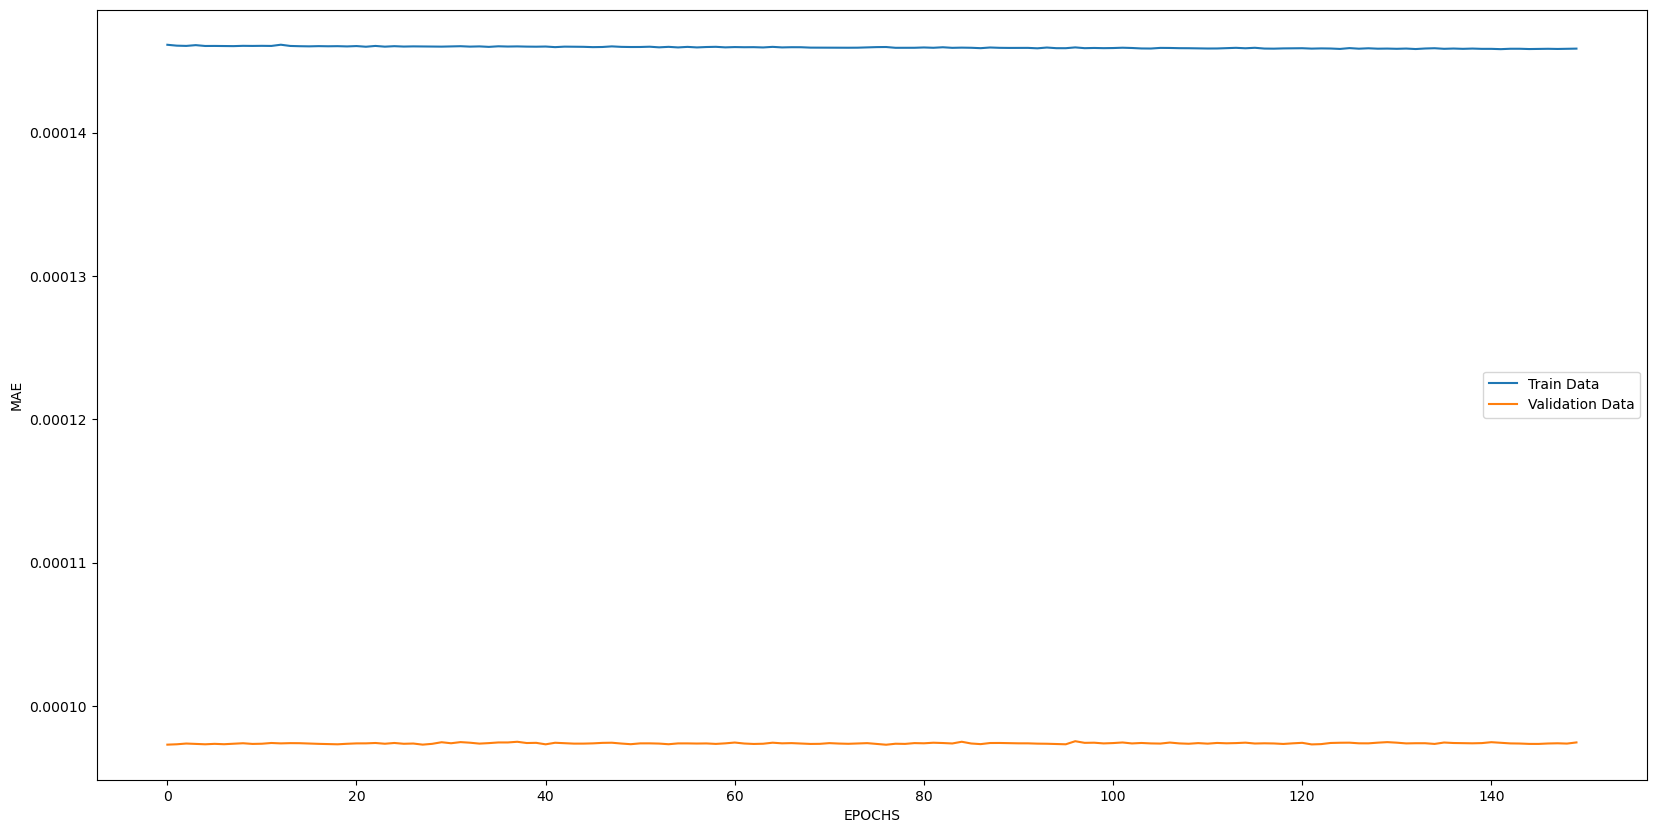

In [104]:
lstm_difflog_model = createLstmModel(x_train_data,outputs=HORIZON)
print(lstm_difflog_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)      

plotHistory(history)

## Multi-Index based on variation

In [188]:
# Loads Data (includes disregarding dates only present in one dataframe)
df, df_other = load_multiple_index(end_date="2022-01-01")

# Cleans PSI-20 unwanted columns leaving only index and close value
global_data_p, size_train_data = selectData(type='univariate', datframe=df) 

# Cleans Foreign unwanted columns leaving only index and close value
global_data_f, size_train_data_f = selectData(type='univariate', datframe=df_other) 

#Renames the column of the close value of the foreign stock exchange
global_data_f.rename(columns = {'Close':'Other1'}, inplace = True)

# Joins the thow tables in one
global_data=global_data_p.join(global_data_f["Other1"])

#NECESSARY TO RECALCULATE
size_train_data=len(global_data)-PERIODS_TO_PREDICT
global_data

,Close,Other1
2018-05-04,5487.790039,5516.049805
2018-05-07,5527.759766,5531.419922
2018-05-08,5539.560059,5521.930176
2018-05-09,5550.390137,5534.629883
2018-05-10,5559.620117,5545.950195
...,...,...
2021-12-27,5534.890137,7140.390137
2021-12-28,5560.790039,7181.109863
2021-12-29,5574.500000,7161.520020
2021-12-30,5571.669922,7173.229980


In [189]:
train_data,test_data = divideData(global_data, size_train_data)
scaled_train_data = diffLogData(train_data, numVariables=train_data.shape[1])

x_train_data = createBivTrainVector(scaled_train_data, scaled_train_data.shape[0])
y_train_data = createTargetVector(scaled_train_data[:,0])


In [190]:

test_data=global_data[size_train_data-LOOK_BACK:].values

scaled_test_data=diffLogData(test_data, numVariables=2)

X_test = createBivTestVector(scaled_test_data)

In [191]:
#EPOCHS=150
lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 50)            10600     
                                                                 
 lstm_7 (LSTM)               (None, 25)                7600      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
86/86 [==============================] - 4s 16ms/step - loss: 1.6286e-04 - val_loss: 9.9322e-05
Epoch 2/150
86/86 [==============================] - 1s 9ms/step - loss: 1.5018e-04 - val_loss: 1.1027e-04
Epoch 3/150
86/86 [==============================] - 1s 9ms/step - loss: 1.5566e-04 - val_loss

## Linear Foreing VAR BASED

In [34]:
df, df_other = load_multiple_index(end_date="2022-08-01")

In [33]:
# Cleans unwanted columns leaving only index and close value
global_data, size_train_data = selectData(type='univariate', datframe=df_other) 

#Divides the data in train_data and test_data
train_data,test_data = divideData(global_data, size_train_data)


In [34]:

#Scales the data
scaled_train_data=diffLogData(train_data)

#Create the vector for X_train_data
x_train_data = createTrainVector(scaled_train_data)

In [37]:
# Cleans unwanted columns leaving only index and close value
global_data_p, size_train_data_p = selectData(type='univariate', datframe=df) 

#Divides the data in train_data and test_data
train_data_p,test_data_p = divideData(global_data_p, size_train_data_p)

#Scales the data
scaled_train_data_p=diffLogData(train_data_p)

#Create the vector for Y_train_data 
y_train_data = createTargetVector(scaled_train_data_p)

In [38]:
#Preaparing the X_test matrix
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data)

print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)



x data

[[ 0.00278256 -0.00171708  0.00229723 ... -0.00143266  0.00992762
   0.00567852]
 [-0.00171708  0.00229723  0.00204327 ...  0.00992762  0.00567852
  -0.00373346]
 [ 0.00229723  0.00204327 -0.00072336 ...  0.00567852 -0.00373346
   0.00365   ]
 ...
 [ 0.01177835  0.003694   -0.00317219 ...  0.00630896 -0.00812205
  -0.00048715]
 [ 0.003694   -0.00317219  0.00950293 ... -0.00812205 -0.00048715
   0.00534708]
 [-0.00317219  0.00950293  0.00715095 ... -0.00048715  0.00534708
  -0.00290327]]

y data - target

[[ 2.21830625e-03]
 [-1.41194092e-03]
 [ 3.10386791e-03]
 [-4.56940278e-03]
 [-3.15022678e-03]
 [ 3.14491895e-03]
 [ 3.46011338e-03]
 [ 9.35371388e-04]
 [ 1.07997931e-03]
 [-2.43990198e-03]
 [-1.63700040e-02]
 [-5.92481721e-03]
 [-1.60145887e-02]
 [ 1.28303073e-02]
 [-4.69483719e-03]
 [ 3.19558833e-03]
 [ 4.78527072e-03]
 [ 2.16292564e-03]
 [-4.77117199e-03]
 [ 1.17947364e-03]
 [ 4.35635611e-03]
 [-1.70582196e-03]
 [-2.91615206e-03]
 [-6.02462809e-03]
 [-7.37692986e-03]
 [-2.34

In [39]:
lstm_difflog_model = createLstmModel(x_train_data)
print(lstm_difflog_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
21/21 [==============================] - 6s 102ms/step - loss: 1.5523e-04 - val_loss: 8.6481e-05
Epoch 2/150
21/21 [==============================] - 1s 54ms/step - loss: 1.5495e-04 - val_loss: 8.6895e-05
Epoch 3/150
21/21 [==============================] - 1s 54ms/step - loss: 1.5512e-04 - val_los

## Using Week Days  BIV

In [76]:
df = load_df_portugal()
global_data, size_train_data = selectData(type='bivariate') 


In [77]:
for i in range (0, len(global_data.index)) :
    global_data.Volume[i] = global_data.index[i].weekday()

C:\Users\queir\AppData\Local\Temp\ipykernel_10776\3607505788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_data.Volume[i] = global_data.index[i].weekday()


In [90]:
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaler2=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler,scaler2)
#The following line reverses the scaling of the weekday
#scaled_train_data[:,1]=train_data[:,1]


In [91]:
x_train_data = createBivTrainVector(scaled_train_data, size_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])

In [92]:
x_train_data

array([[[0.66142175, 1.        ],
        [0.67301952, 0.        ],
        [0.68277192, 0.25      ],
        ...,
        [0.71128137, 0.75      ],
        [0.70189929, 1.        ],
        [0.6873122 , 0.        ]],

       [[0.67301952, 0.        ],
        [0.68277192, 0.25      ],
        [0.67909251, 0.5       ],
        ...,
        [0.70189929, 1.        ],
        [0.6873122 , 0.        ],
        [0.68708714, 0.25      ]],

       [[0.68277192, 0.25      ],
        [0.67909251, 0.5       ],
        [0.6870217 , 0.75      ],
        ...,
        [0.6873122 , 0.        ],
        [0.68708714, 0.25      ],
        [0.69708304, 0.5       ]],

       ...,

       [[0.94719823, 1.        ],
        [0.91393797, 0.        ],
        [0.88062681, 0.25      ],
        ...,
        [0.80715397, 0.25      ],
        [0.79970062, 0.5       ],
        [0.77815803, 0.75      ]],

       [[0.91393797, 0.        ],
        [0.88062681, 0.25      ],
        [0.87143007, 0.5       ],
        .

In [81]:

#x_train_data[:,:-1,1]=0
#x_train_data

In [93]:
test_data=global_data[size_train_data-LOOK_BACK:].values
scaled_test_data=scaleData(test_data,scaler,scaler2)
#The following line reverses the scaling of the weekday
#scaled_test_data[:,1]=test_data[:,1]
X_test = createBivTestVector(scaled_test_data)

#X_test[:,:-1,1]=0
X_test


array([[[0.90397235, 0.5       ],
        [0.86656508, 0.75      ],
        [0.91446101, 1.        ],
        ...,
        [0.64655754, 1.        ],
        [0.64669244, 0.        ],
        [0.73706011, 0.25      ]],

       [[0.86656508, 0.75      ],
        [0.91446101, 1.        ],
        [0.91421371, 0.        ],
        ...,
        [0.64669244, 0.        ],
        [0.73706011, 0.25      ],
        [0.76419202, 0.5       ]],

       [[0.91446101, 1.        ],
        [0.91421371, 0.        ],
        [0.87179789, 0.25      ],
        ...,
        [0.73706011, 0.25      ],
        [0.76419202, 0.5       ],
        [0.7746922 , 0.75      ]],

       ...,

       [[0.61167703, 1.        ],
        [0.64594011, 0.        ],
        [0.65149864, 0.25      ],
        ...,
        [0.7954003 , 0.5       ],
        [0.86638522, 0.75      ],
        [0.8382652 , 1.        ]],

       [[0.64594011, 0.        ],
        [0.65149864, 0.25      ],
        [0.67366697, 0.5       ],
        .

In [94]:
lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10600     
                                                                 
 lstm_7 (LSTM)               (None, 25)                7600      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
112/112 [==============================] - 5s 28ms/step - loss: 0.0146 - val_loss: 0.0051
Epoch 2/150
112/112 [==============================] - 2s 22ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 3/150
112/112 [==============================] - 2s 22ms/step - loss: 0.0025 - val_loss: 0.0030
Epo


# == PREDICTIONS ==

##### Prediction Benchmark

In [50]:

def generateBenchmark(data=global_data,size=size_train_data): #%% Day - Before Prediction function
        day_before_price=data.iloc[size-1:].copy()
        day_before_price_copy = day_before_price.copy()

 
        for i in range(1,day_before_price.size):
                day_before_price['Close'][i] = day_before_price_copy['Close'][i-1].copy()

        return day_before_price.iloc[1:]


##### Evaluate Predictions:

In [51]:
def testPredictionsScore(data=test_data, type=""):
    
    if (type=="categorical"):
        data = data[LOOK_BACK+1:,0]
    else:
        data = data[LOOK_BACK:,0]
 

    print('==================================')
    testScore = np.sqrt(mean_squared_error(data, predicted_stock_price))
    print('Test Score: %.2f RMSE' % (testScore))
    print('==================================')    

In [52]:
## TO check if necessary (only for fopreign becaus of lookback)
def testPredictionsScore_f(actual=test_data, type="", predicted=""):
    
    print('==================================')
    testScore = np.sqrt(mean_squared_error(actual, predicted))
    print('Test Score: %.2f RMSE' % (testScore))
    print('==================================')    

In [53]:
def testDayBeforeScore(actual, predicted):
    
    #testScore = np.sqrt(mean_squared_error(global_data.iloc[size_train_data:], day_before_price['Close']))
    testScore = np.sqrt(mean_squared_error(actual, predicted))
    #predicted.to_numpy()

    print('==================================')
    print('Test Score Day before: %.2f RMSE' % (testScore))
    print('==================================')

#### Plotting the results

In [54]:
def fillDataForPlotting (history,predicted,benchmark): 
    #Setting Vectors for plotting
    tr_data = history.iloc[:size_train_data]
    tt_data = history.iloc[size_train_data:]
    tt_data = tt_data.assign(Predictions=predicted)
    if (not benchmark.empty):
        tt_data = tt_data.assign(Day_Before=benchmark)
    return tr_data,tt_data

In [55]:
def plotAllHistory (train_data,test_data,title): 
    #Plotting all history
    plt.plot(train_data["Close"], label='Historical Data')
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    #plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - All history", fontsize=25)
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Index',fontsize=15)
    plt.legend(fontsize=15)
    plt.show()  

In [56]:
def plotPredictedPeriod (test_data, title,printBenchmark):
    #Plot predicted Period
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    if printBenchmark:
        plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - Predicted Period", fontsize=25)
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Index',fontsize=15)
    plt.legend(fontsize=15)
    plt.show()  


In [57]:
def plotResults(history=global_data, predicted="",benchmark=pd.DataFrame(), title=""):
    tr_data,tt_data = fillDataForPlotting(history,predicted,benchmark);
    plotAllHistory(tr_data,tt_data, title);
    #Only prints benchmark if not empty
    plotPredictedPeriod(tt_data,title,not benchmark.empty);


### Running Predictions

##### Linear Model

In [ ]:
#Linear model
day_before_price = generateBenchmark(global_data,size_train_data)
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)


In [192]:
testPredictionsScore(test_data, predicted_stock_price)


Test Score: 43.01 RMSE


C:\Users\queir\AppData\Local\Temp\ipykernel_19948\2412142912.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (type=="categorical"):


In [193]:

testDayBeforeScore(global_data.iloc[size_train_data:], day_before_price)


Test Score Day before: 42.33 RMSE


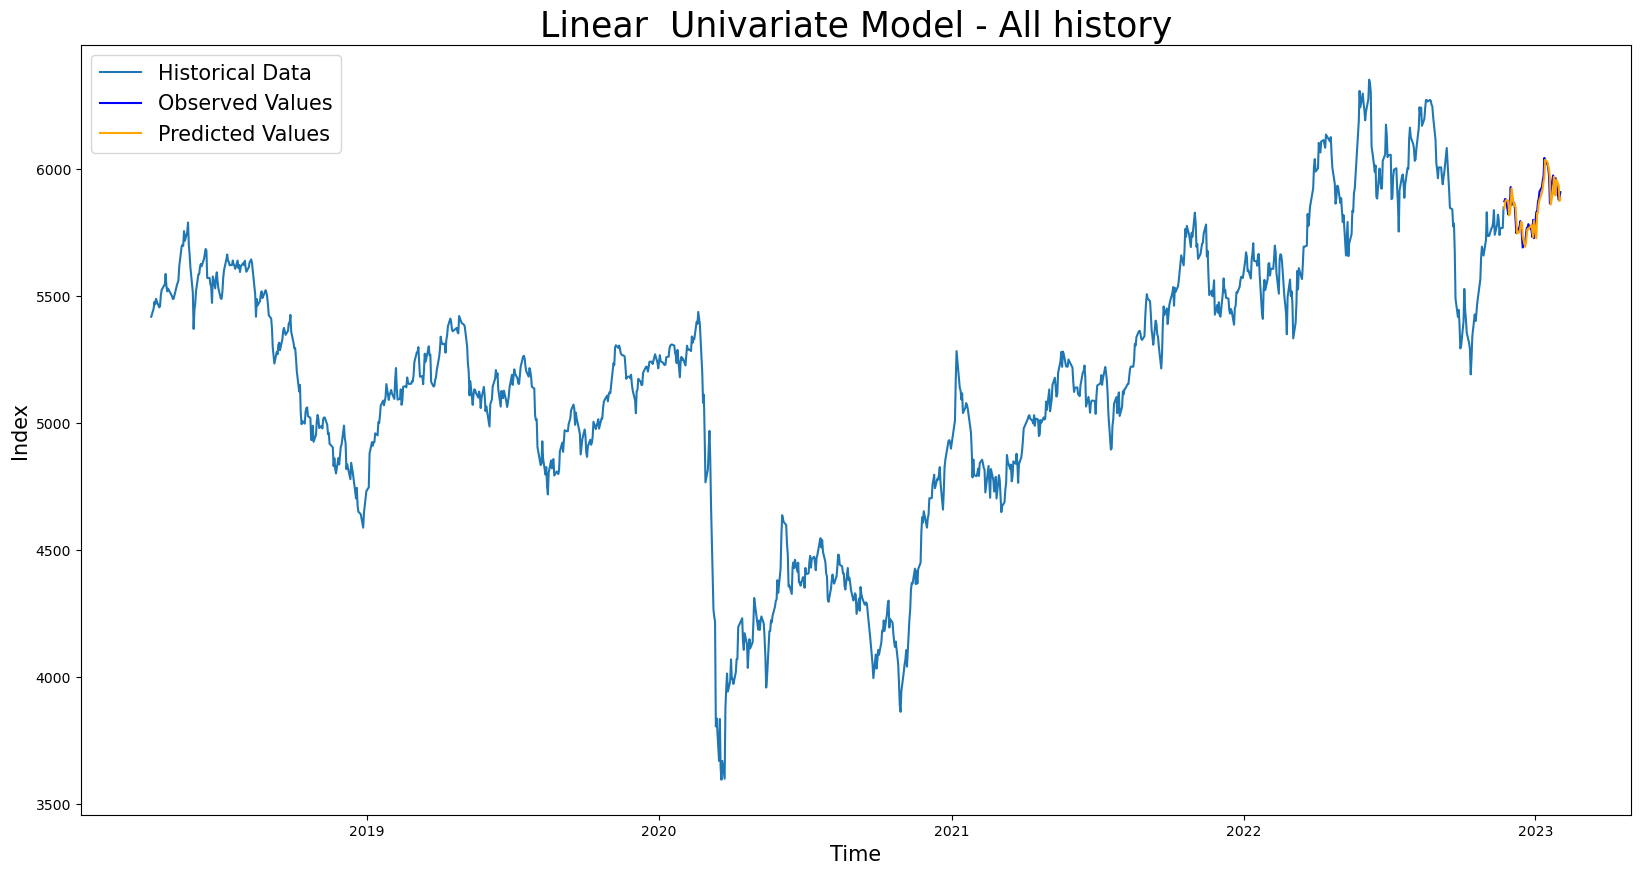

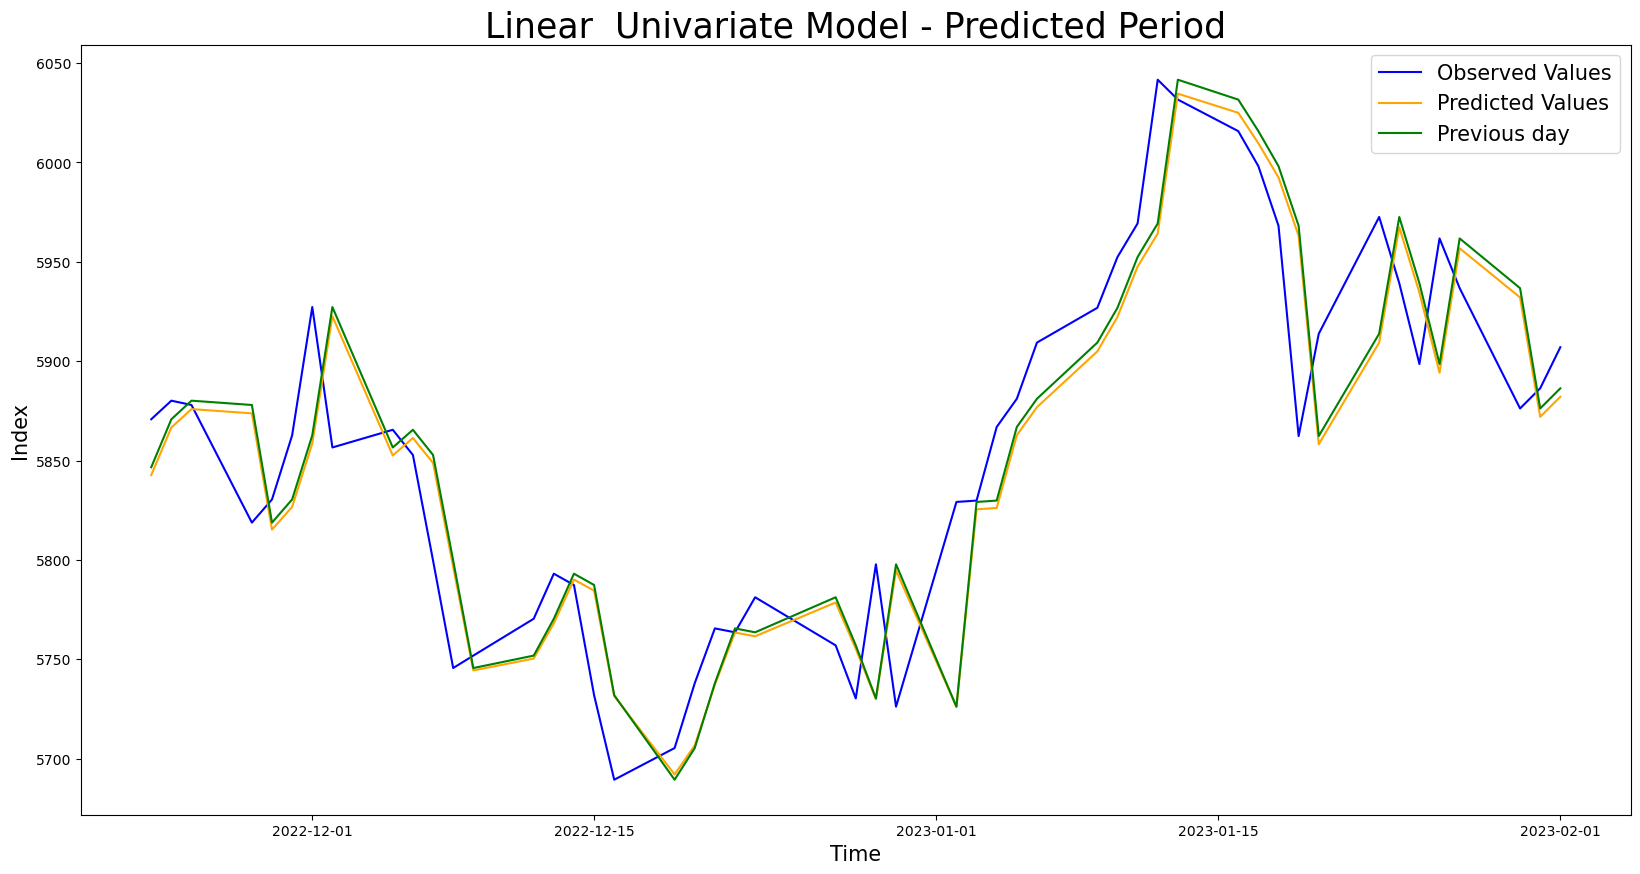

In [186]:
plotResults(predicted=predicted_stock_price,benchmark=day_before_price, title="Linear  Univariate Model")

##### Multi-Index Model


In [105]:
#Bivariate model
predicted_stock_price=lstm_biv_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)


23/23 [==============================] - 1s 11ms/step


In [106]:
np.sqrt(mean_squared_error(test_data[LOOK_BACK:,0], predicted_stock_price))


74.71140902165386

In [107]:
testPredictionsScore()


ValueError: Found input variables with inconsistent numbers of samples: [0, 722]

In [109]:
# For bivariate use data=global_data.drop(['Other1']
day_before_price = generateBenchmark(data=global_data.drop(['Other1'], axis=1))


testDayBeforeScore(predicted=day_before_price, actual=test_data[LOOK_BACK:,0])

Test Score Day before: 67.55 RMSE


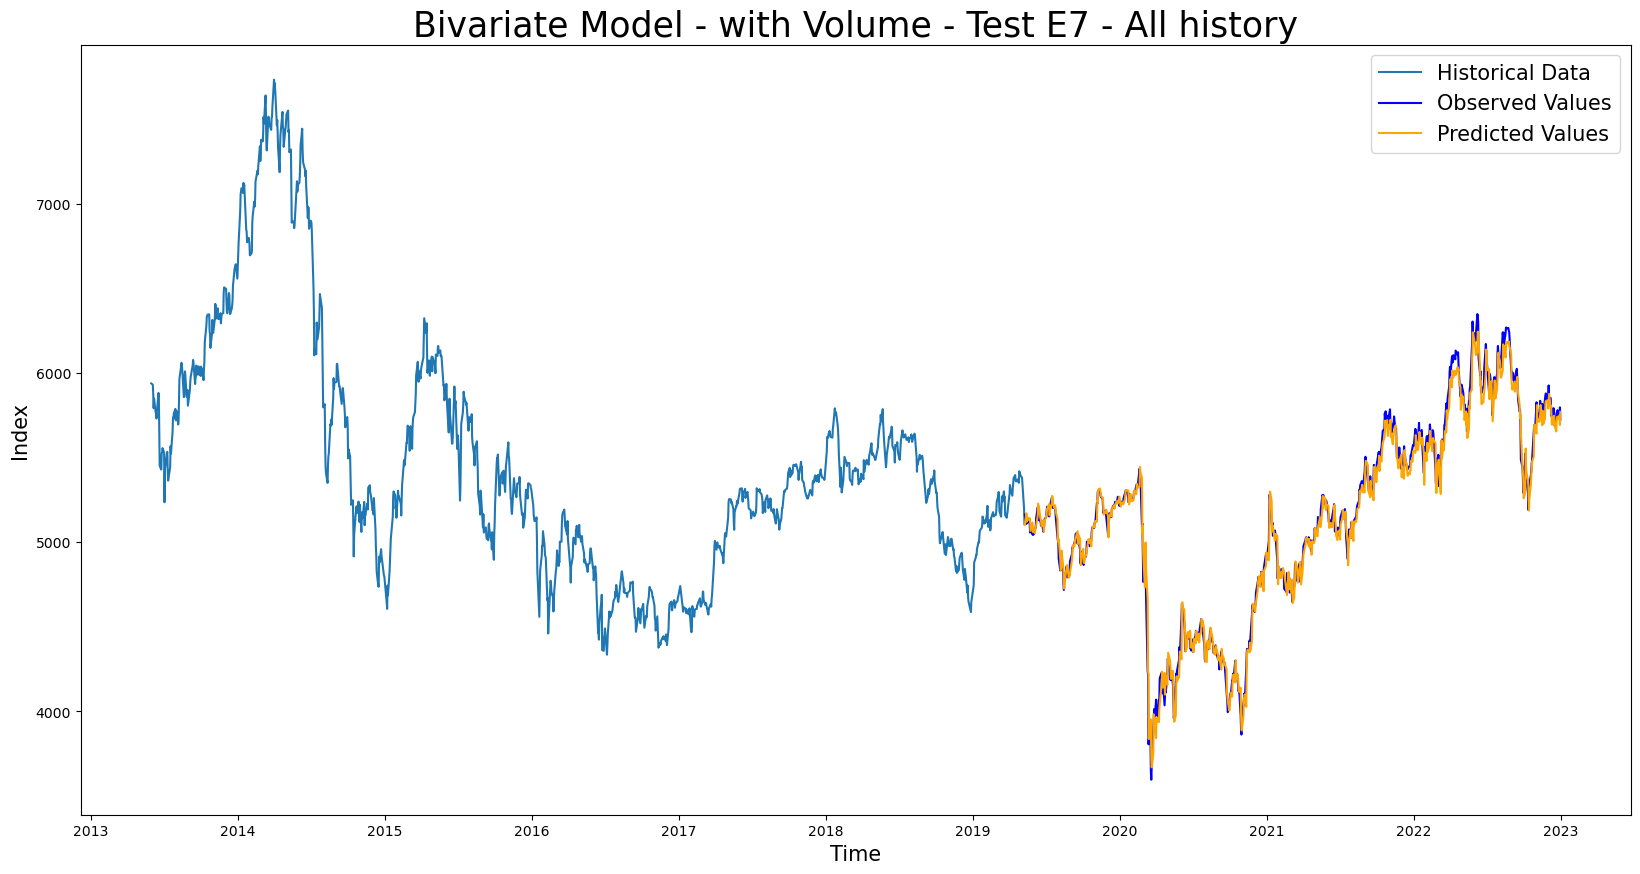

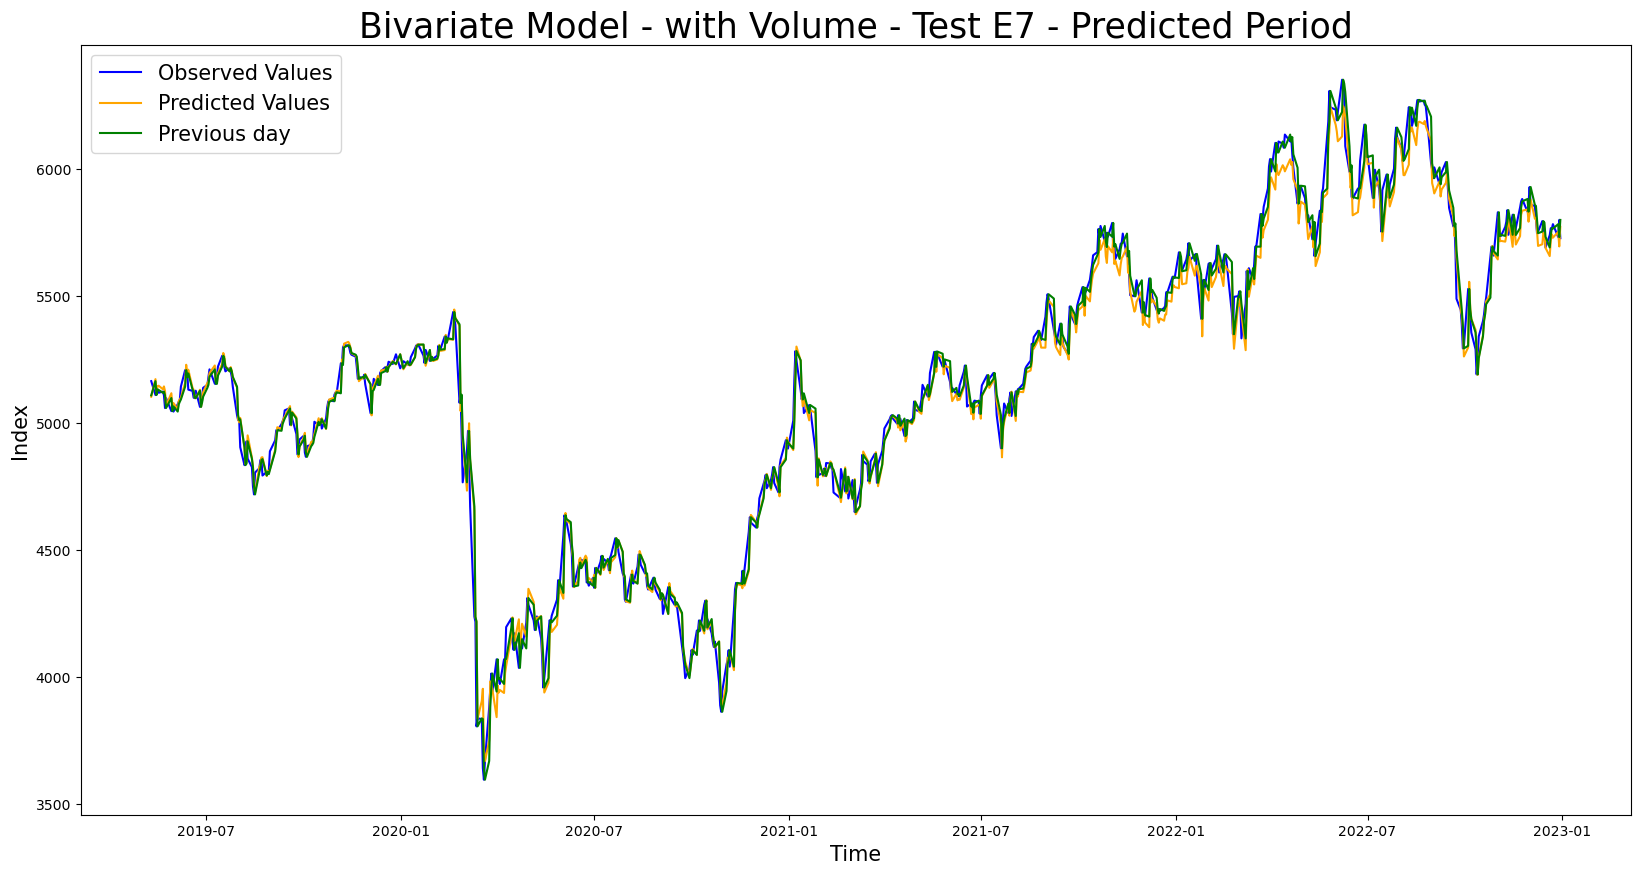

In [110]:
# For bivariate use data=global_data.drop(['Volume']
plotResults(history=global_data.drop(['Other1'], axis=1),predicted=predicted_stock_price,benchmark=day_before_price, 
            title="Bivariate Model - with Volume - Test E7")



##### DiffLog Model


In [ ]:
#Difflog Model
diff_logged_predictions=lstm_difflog_model.predict(X_test)

In [78]:
#This is the correct one
predicted_stock_price = undiffLogData2(test_data[LOOK_BACK:], diff_logged_predictions);


In [79]:
testPredictionsScore(test_data, predicted_stock_price)
#testDayBeforeScore()

Test Score: 48.25 RMSE


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_46616\2412142912.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (type=="categorical"):


In [80]:
day_before_price = generateBenchmark(global_data,size_train_data)
testDayBeforeScore(global_data.iloc[size_train_data:], day_before_price)

Test Score Day before: 51.03 RMSE


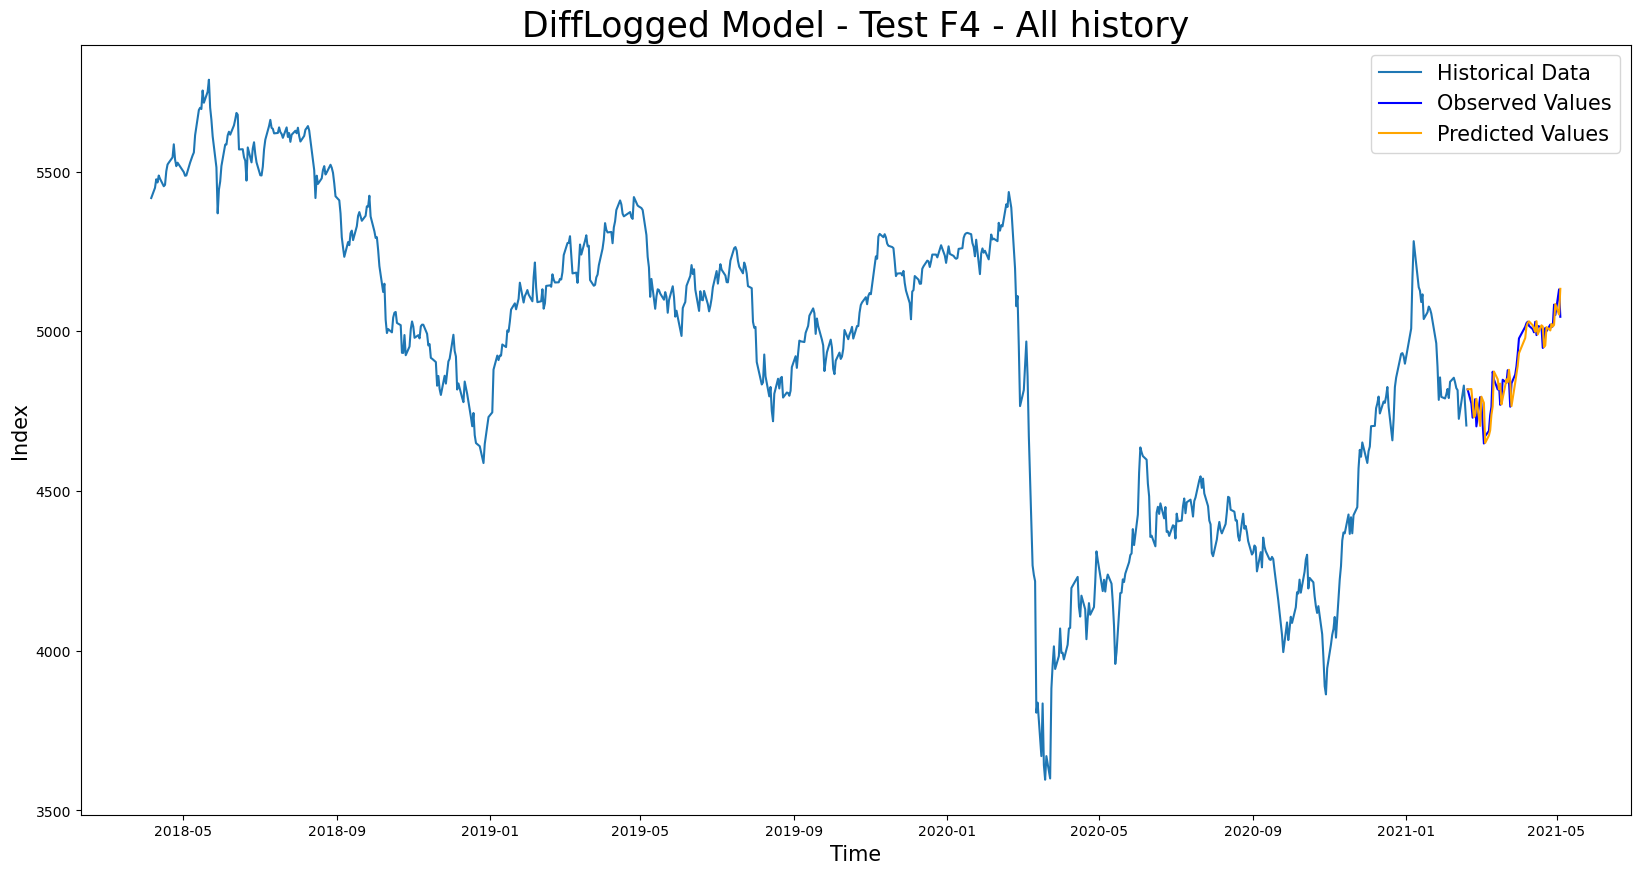

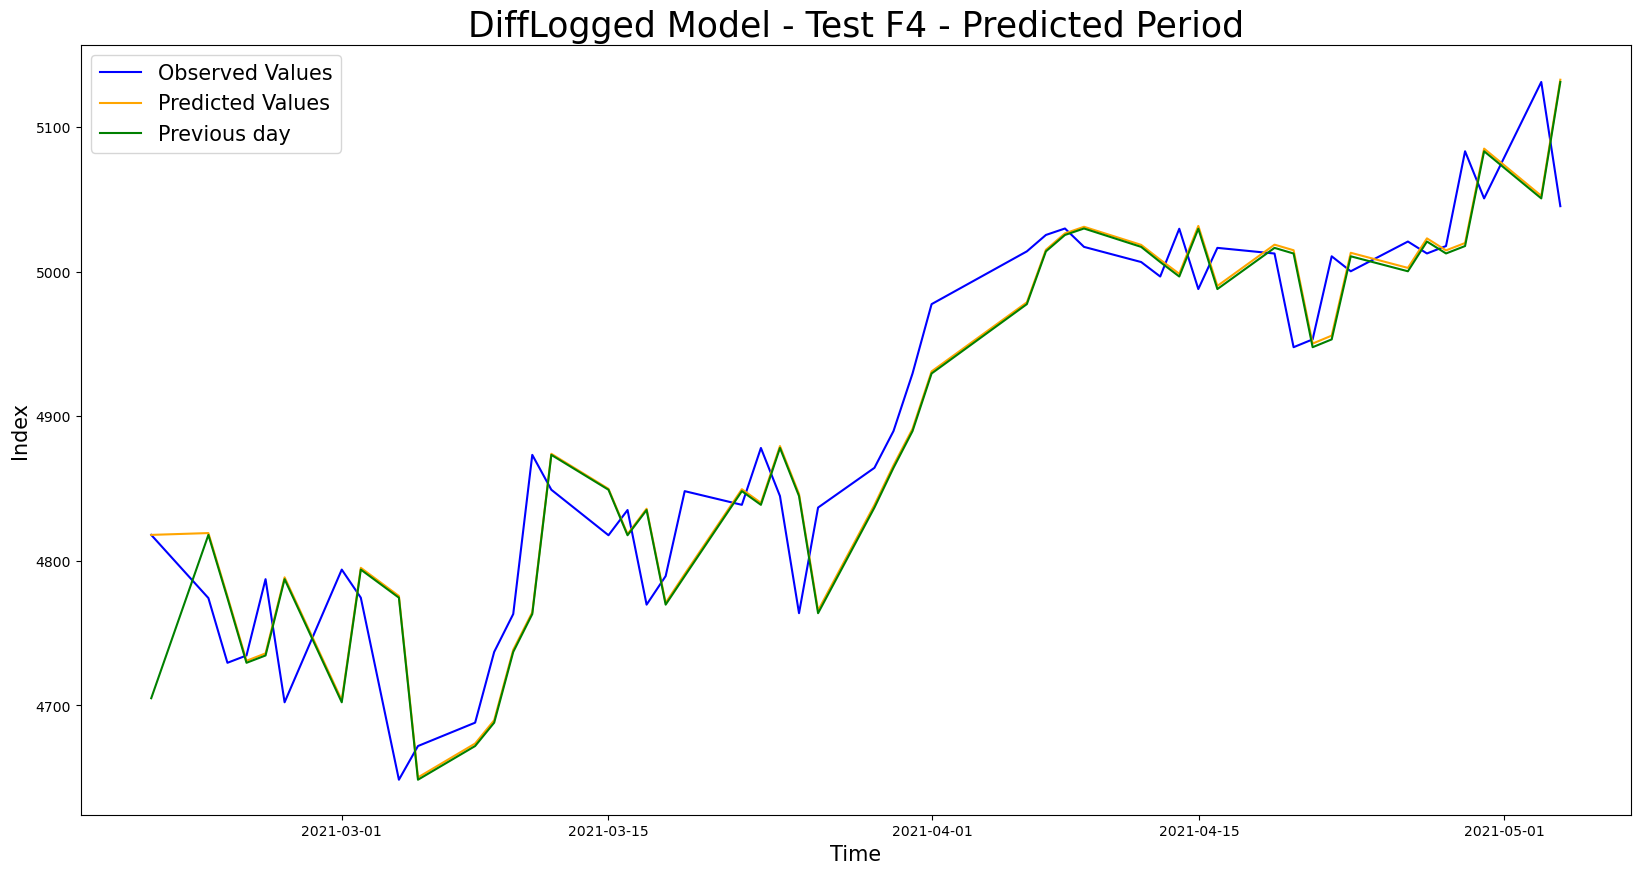

In [81]:
plotResults(history=global_data, predicted=predicted_stock_price,benchmark=day_before_price, title="DiffLogged Model - Test F4")

##### Classification Model

In [161]:
#Category Model
predicted_stock_cat=lstm_class_model.predict(X_test)
print("Test C")
predicted_stock_cat

2/2 [==============================] - 1s 5ms/step
Test C


array([[0.20053099, 0.40272638, 0.39674255],
       [0.12663765, 0.6538281 , 0.21953432],
       [0.18890291, 0.67526543, 0.13583161],
       [0.29152542, 0.5105639 , 0.1979106 ],
       [0.40924615, 0.4592924 , 0.13146155],
       [0.24838002, 0.55255365, 0.19906625],
       [0.08839533, 0.65970856, 0.25189623],
       [0.3064554 , 0.35178405, 0.34176067],
       [0.33391213, 0.29765797, 0.36843   ],
       [0.11668763, 0.5099477 , 0.37336475],
       [0.07959361, 0.62216055, 0.29824585],
       [0.5679509 , 0.32799459, 0.10405455],
       [0.54315424, 0.320318  , 0.1365277 ],
       [0.37354335, 0.48128182, 0.14517488],
       [0.34438798, 0.34345832, 0.3121537 ],
       [0.23018861, 0.25629994, 0.5135115 ],
       [0.51758206, 0.39280012, 0.08961779],
       [0.5332728 , 0.36110047, 0.10562679],
       [0.36133757, 0.494991  , 0.14367142],
       [0.05732381, 0.67735946, 0.26531672],
       [0.04061703, 0.6775724 , 0.2818105 ],
       [0.11913333, 0.43541992, 0.44544676],
       [0.

In [81]:
y_train_data[:,0].sum()
y_train_data[:,1].sum()

579.0

In [162]:

predictions=np.argmax(predicted_stock_cat, axis=1)
observations =  np.argmax(Y_test, axis=1)

In [184]:
#print(predicted_stock_cat)
from sklearn.metrics import accuracy_score

print("Predicions:")
print(predictions)

print("Total of " + str(len(predictions)) + " values.\n")

print("Observed:")
print(observations)
print(str(len(observations)) + " values.\n")

print("Accuracy:" + str(accuracy_score(observations, predictions)*100) +"%.")

##testPredictionsScore("categorical")




Predicions:
[1 1 1 1 1 1 1 1 2 1 1 0 0 1 0 2 0 0 1 1 1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1
 0 0 0 0 0 2 0 0 0 0 0 1]
Total of 49 values.

Observed:
[1 1 0 1 2 2 0 1 1 0 0 1 2 2 1 0 0 1 2 2 1 2 0 0 2 0 2 1 2 1 2 1 2 1 2 1 1
 0 0 0 2 2 0 0 2 0 0 1 2]
49 values.

Accuracy:38.775510204081634%.


In [164]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(observations, predictions)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix




array([[ 7,  7,  2],
       [ 4, 10,  2],
       [ 4, 11,  2]], dtype=int64)

<AxesSubplot: title={'center': '"C2" Heatmap'}>

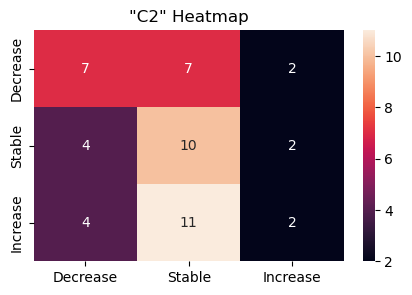

In [185]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Stable","Increase"],
                  columns = ["Decrease", "Stable","Increase"])
plt.figure(figsize = (5,3))
plt.title('"C2" Heatmap')
sn.heatmap(df_cm,annot=True)

In [166]:
#PARA ELIMINAR
#Making a list with the actual index value variations.

# Selecting the 50 last values and logging
test_data_log = np.log(test_data[90:])
test_data_diff = test_data_log[0:49,]

# iterating the log array and returing the diff to the test_data_diff array
for i in range (len(test_data_log)-1) :
    test_data_diff[i] = test_data_log[i+1] - test_data_log[i]

observed = test_data_diff.T[0]

#test_obs = createTargetClassVector(test_data, numCat=3)

print(observed)





[]


#### Linear with foreign data

In [92]:
#gets the values from previous day as a benchmark
day_before_price = generateBenchmark(global_data_p,size_train_data)

# the model makes its predictiona (scaled data)
predicted_stock_price=lstm_model.predict(X_test)


2/2 [==============================] - 1s 13ms/step


In [93]:

#We (un)scale the data back.
pred=scaler_p.inverse_transform(predicted_stock_price)

In [94]:
testPredictionsScore_f(actual=test_data_p, predicted=pred)
testDayBeforeScore(test_data_p,day_before_price)

Test Score: 1651.22 RMSE
Test Score Day before: 75.02 RMSE


In [ ]:
plt.plot(predicted_stock_price, label='Predicted')
plt.plot(scaled_train_data_p, label='actual')
plt.plot(scaled_train_data, label='NYSE')
plt.xlabel("Years", fontsize=15)
plt.ylabel("Stock index value")
plt.title("The Psi-20 and "+NAME_FOREIGN, fontsize=20)
plt.legend(fontsize=15)
plt.show()

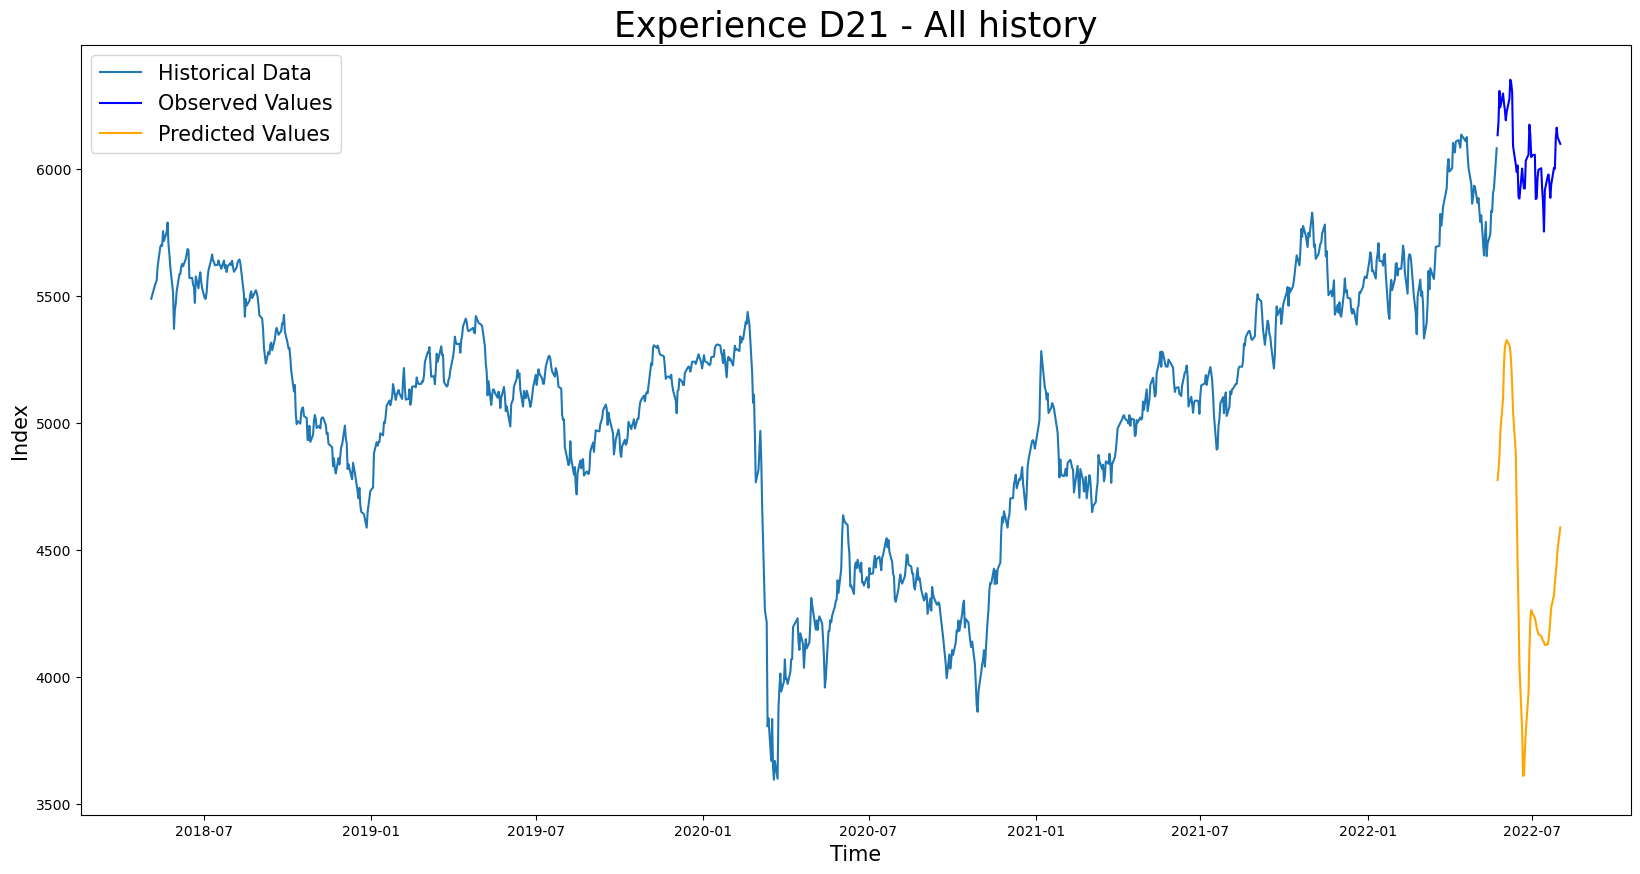

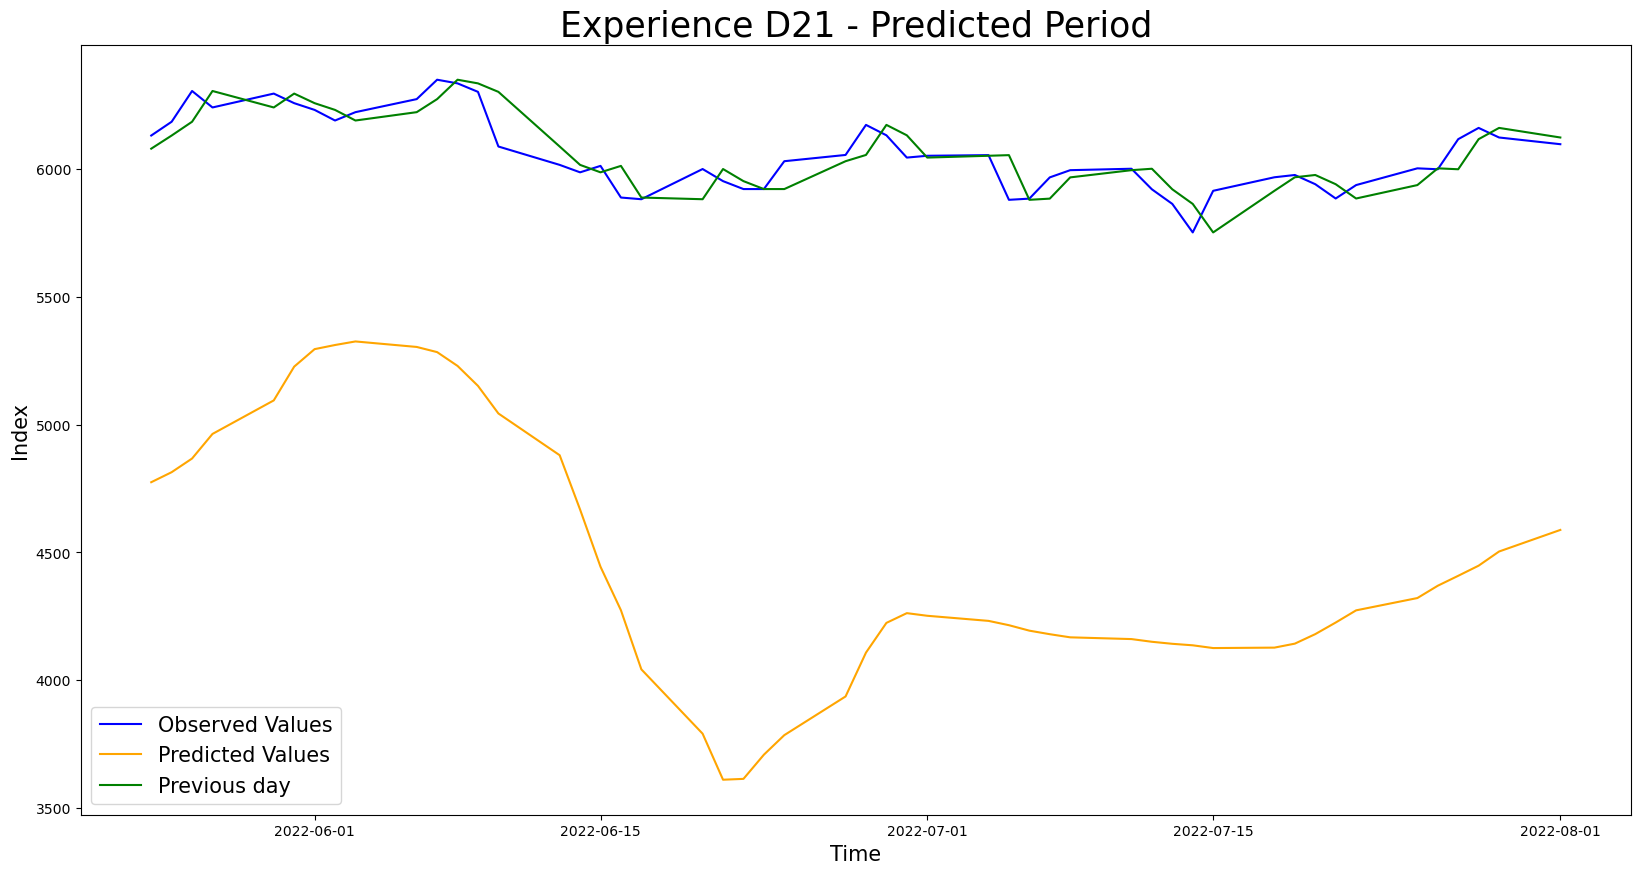

In [96]:
plotResults(history=global_data_p, predicted=pred,benchmark=day_before_price,title="Experience D21")



#### Multi Predictor

In [105]:
#Difflog Model
diff_logged_predictions=lstm_difflog_model.predict(X_test)

1/1 [==============================] - 0s 469ms/step


In [106]:
predicted_stock_price= undiffLogData(diff_logged_predictions,test_data[LOOK_BACK])
predicted_stock_price=np.expand_dims(predicted_stock_price, axis=1)  

In [ ]:
day_before_price = generateBenchmark(global_data,size_train_data)[:-1]


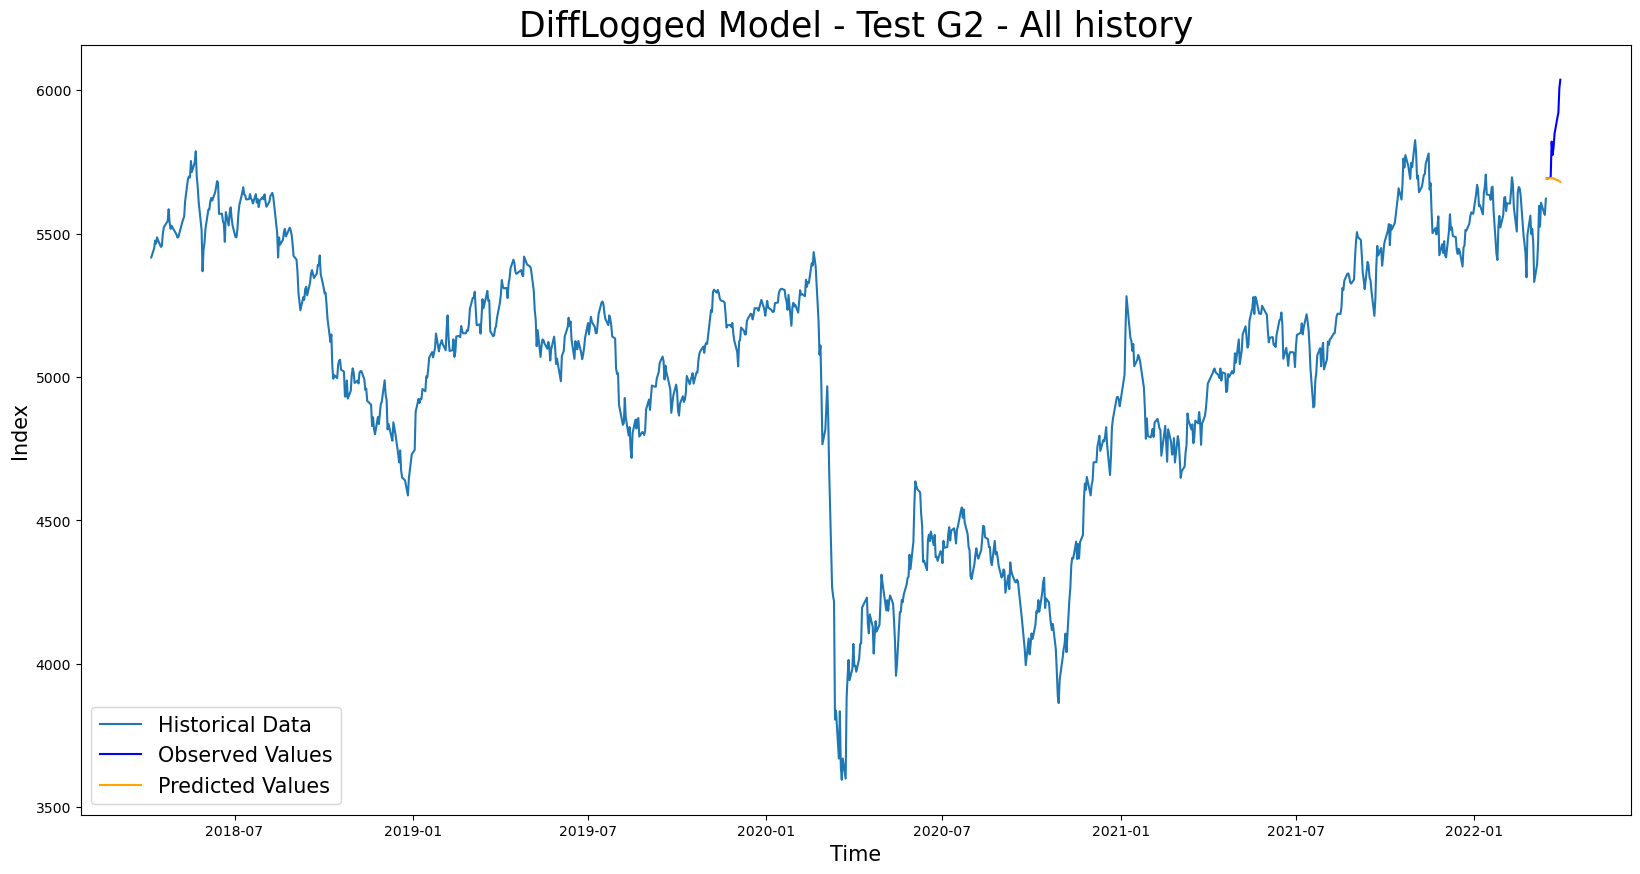

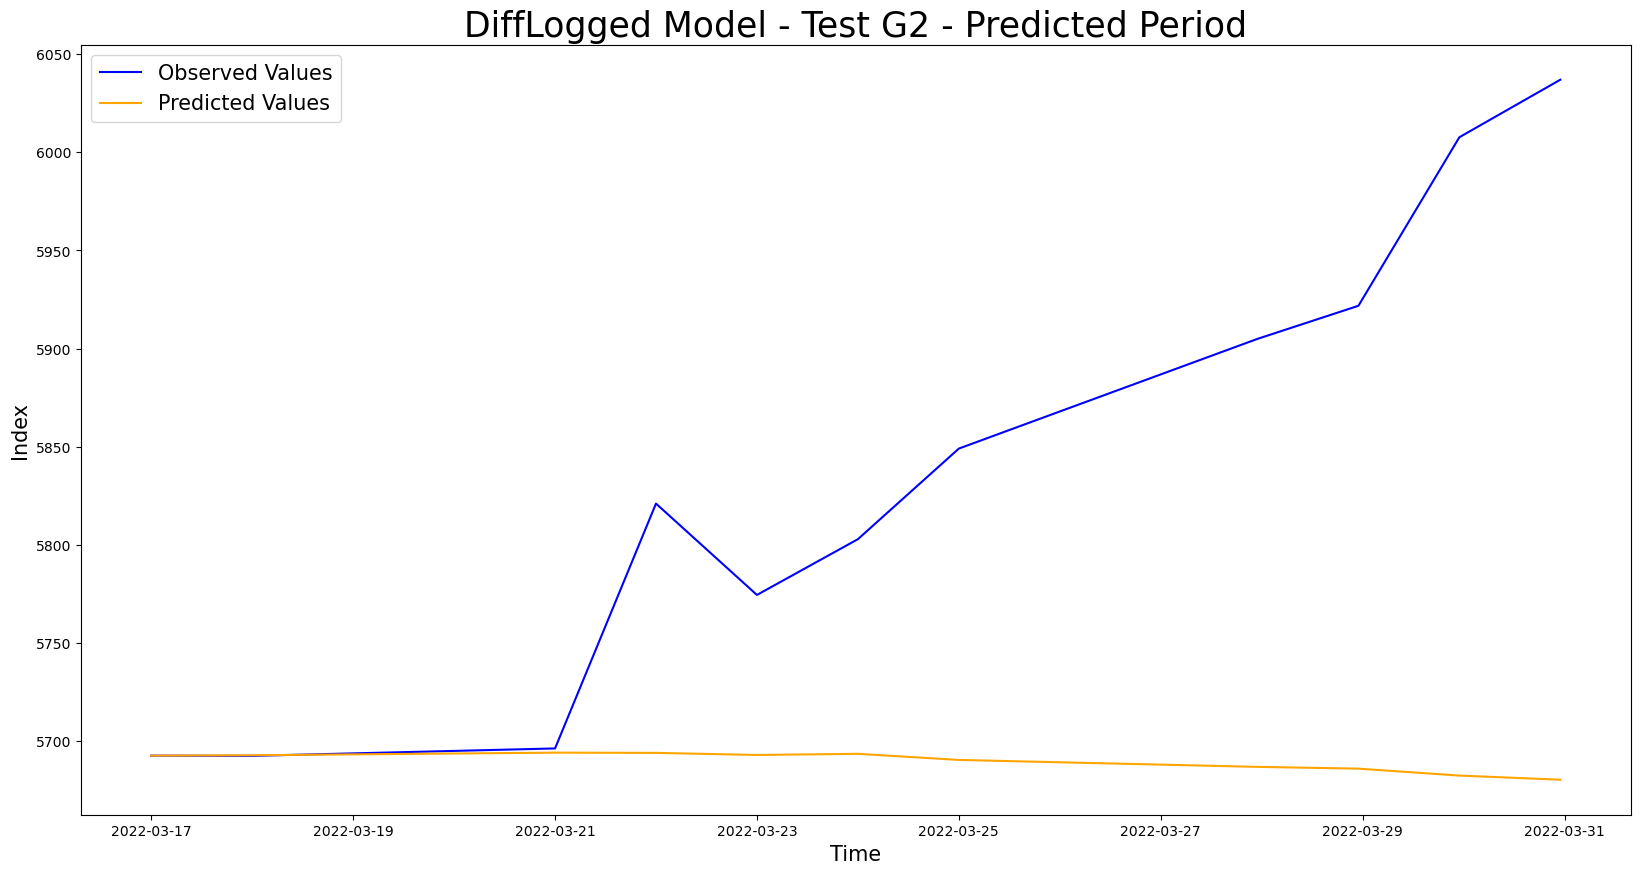

In [110]:
plotResults(history=global_data[:-1], predicted=predicted_stock_price, title="DiffLogged Model - Test G2")

#### Multi-index Variation

In [192]:
#Bivariate model
predicted_stock_var=lstm_biv_model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [193]:
#This is the correct one
predicted_stock_price = undiffLogData2(np.expand_dims(test_data[LOOK_BACK:,0], axis=1), predicted_stock_var);

In [194]:
testPredictionsScore(test_data, predicted_stock_price)

Test Score: 49.42 RMSE


C:\Users\queir\AppData\Local\Temp\ipykernel_17224\2412142912.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (type=="categorical"):


In [197]:
# For bivariate use data=global_data.drop(['Volume']
day_before_price = generateBenchmark(data=global_data.drop(['Other1'], axis=1))

In [199]:
# For some strange reason the previous cell was not working so the below is the workaround

d = global_data.drop(['Other1'], axis=1);
dbp=d[size_train_data-1:].copy()
dbp_copy = dbp.copy()

for i in range(1,dbp.size):
        dbp['Close'][i] = dbp_copy['Close'][i-1].copy()
day_before_price=dbp.iloc[1:]
        

In [200]:

testDayBeforeScore(predicted=day_before_price, actual=test_data[LOOK_BACK:,0])

Test Score Day before: 49.36 RMSE


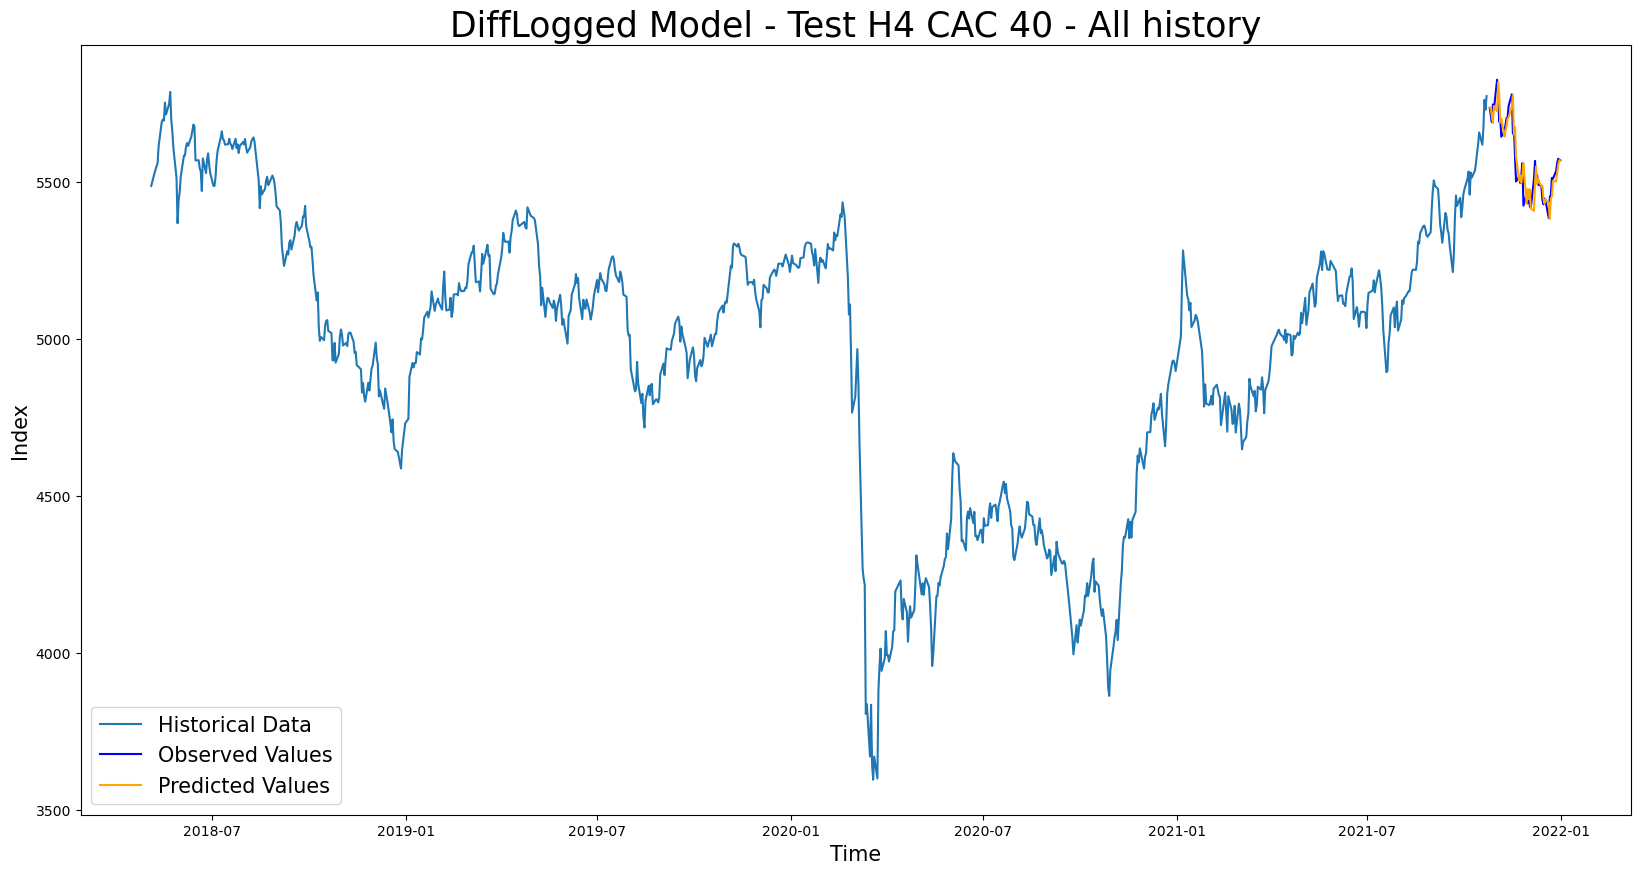

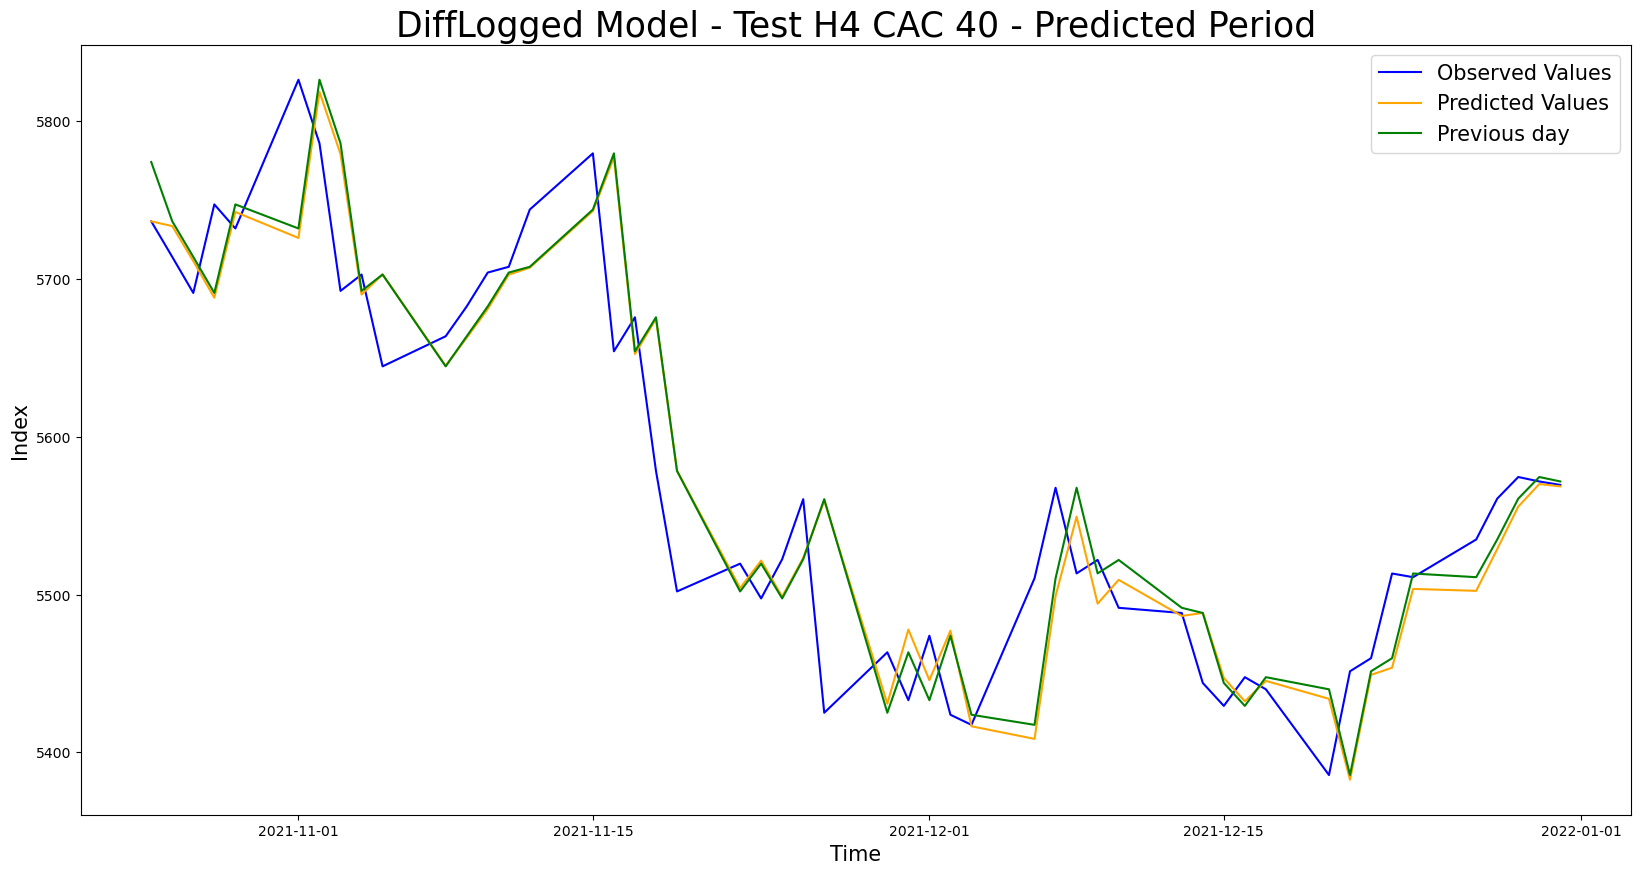

In [201]:
plotResults(history=global_data, benchmark=day_before_price, predicted=predicted_stock_price, title="DiffLogged Model - Test H4 " + NAME_FOREIGN)


#### Foreign VAR

In [50]:
#gets the values from previous day as a benchmark
day_before_price = generateBenchmark(global_data_p,size_train_data)

# the model makes its predictiona (scaled data)
predicted_stock_var=lstm_model.predict(X_test)

2/2 [==============================] - 0s 9ms/step


In [ ]:
#This is the correct one
predicted_stock_price = undiffLogData2(test_data[LOOK_BACK:], predicted_stock_var);

## Clear All

In [204]:
globals().clear

<function dict.clear>